<a href="https://colab.research.google.com/github/jehyunlee/datastory/blob/main/2021/movie/movie_1_genres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[데이터스토리] 데이터로 보는 개봉 영화 (1) 장르**

# **0. 라이브러리 업그레이드 및 한글 사용 설정**

## **0.1. Matplotlib, seaborn, pandas**

In [ ]:
# Step 1. Matplotlib 업그레이드
!pip install matplotlib -U
!pip install seaborn -U
!pip install pandas -U

# Step 2. 한글 설치 및 사용 설정
!sudo apt-get install -y fonts-nanum 
!sudo fc-cache -fv  
!rm ~/.cache/matplotlib -rf

# Step 3. 셀 실행 후 런타임 재시작

     |████████████████████████████████| 10.3 MB 5.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 292 kB 5.4 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1
     |████████████████████████████████| 11.3 MB 5.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.3 which is incompatible.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (6,967 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 148492 files and d

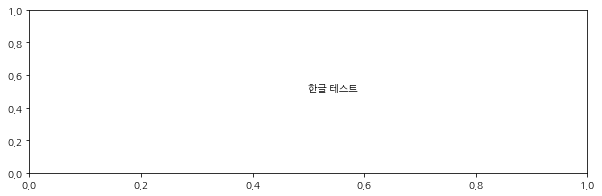

In [ ]:
# Step 4. 한글 글꼴 설정
import matplotlib.pyplot as plt

plt.rcParams['font.family']=['NanumGothic', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

# 한글 설정 확인
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,3))
ax.text(0.5, 0.5, "한글 테스트")
plt.show()

# **1. 개발 환경 설정**

## **1.1. 기본 라이브러리**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import requests
from copy import deepcopy

sns.set_context("talk")
sns.set_style("whitegrid")

pd.options.display.max_columns=50

# seaborn 설정에 의해 파괴되는 한글 설정을 재설정
plt.rcParams['font.family']=['NanumGothic', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

## **1.2. KOBIS API Keys**

In [ ]:
# KOBIS OPEN API 서비스에서 키 발급 필요 : http://www.kobis.or.kr/kobisopenapi/homepg/main/main.do 
APIKEY = '본인의_API_KEY'

# **2. 데이터 확보**

## **2.1. API 활용 KOBIS 영화 목록 데이터 다운로드**
* 데이터 다운로드는 1960-2021년. 
* 다운받은 후 1971-2020만 추출해서 사용

In [ ]:
# 영화 데이터 보관 디렉토리
!mkdir data

In [ ]:
%%time

# 영화 목록 다운로드
url = 'http://kobis.or.kr/kobisopenapi/webservice/rest/movie/searchMovieList.json'

cols_movielist = ['movieCd', 'movieNm', 'movieNmEn', 'prdtYear', 'openDt', 'typeNm', 'prdtStatNm', 'nationAlt', 'genreAlt', 'repNationNm', 'repGenreNm', 'directors', 'companys', 'openYear']
df_movielist_raw = pd.DataFrame(columns=cols_movielist)

for p in range(1000):
    # 영화개봉년도 1961~2021 검색. 한 페이지에 100개 아이템, 총 900페이지 = 최대 10만개 데이터
    r = requests.get(url, params={'key':APIKEY, 'openStartDt':'1960', 'openEndDt':'2021', 'itemPerPage':'100', 'curPage':str(p+1)}) 
    df_ = pd.DataFrame(r.json()['movieListResult']['movieList'])
    df_movielist_raw = pd.concat([df_movielist_raw, df_], axis=0)
    df_movielist_raw.to_pickle("./data/df_movielist_raw.pkl")

# 제작년도 결측치 처리, 타입 변환
df_movielist_raw.loc[df_movielist_raw["prdtYear"] == "", "prdtYear"] = np.nan
df_movielist_raw.loc[~df_movielist_raw["prdtYear"].isna(), "prdtYear"] = df_movielist_raw.loc[~df_movielist_raw["prdtYear"].isna()]["prdtYear"].astype(int)

# 개봉년도 추출, 타입 변환
df_movielist_raw["openYear"]=df_movielist_raw["openDt"].apply(lambda x: x[:4])
df_movielist_raw["openYear"]=df_movielist_raw["openYear"].astype(int)

# 개봉일자 타입 변환
df_movielist_raw["openDt"]=df_movielist_raw["openDt"].astype(int)

# 개봉일자 기준 정렬
df_movielist_raw.sort_values("openDt")
df_movielist_raw.reset_index(drop=True, inplace=True)

# 파일 저장
df_movielist_raw.to_pickle("./data/df_movielist_raw.pkl")

CPU times: user 2min 28s, sys: 8.45 s, total: 2min 37s
Wall time: 16min 12s


In [ ]:
# API 활용 다운로드에 15분 가량 소요 (Colab 기준)
# 본인 google drive 등을 활용해 데이터 백업 권장.
df_movielist_raw = pd.read_pickle("./data/df_movielist_raw.pkl")

## **2.2.영화 목록 데이터 정제 `df_movielist`**

### **2.2.1. 범위 제한, 결측치 제거** 

In [ ]:
df_movielist_raw = pd.read_pickle("./data/df_movielist_raw.pkl")

# 1971년 이후로 범위 제한
df_movielist = df_movielist_raw.query("1971 <= openYear <= 2020")
# 개봉영화로 범위 제한
df_movielist = df_movielist.query("prdtStatNm == '개봉'")
print(df_movielist.shape)
df_movielist.head()

(23419, 14)


,movieCd,movieNm,movieNmEn,prdtYear,openDt,typeNm,prdtStatNm,nationAlt,genreAlt,repNationNm,repGenreNm,directors,companys,openYear
10,20139221,그래비티,Gravity,2013,20131017,장편,개봉,미국,"SF,드라마",미국,SF,[{'peopleNm': '알폰소 쿠아론'}],[],2013
23,20201002,조제,Josée,2020,20201210,장편,개봉,한국,"멜로/로맨스,드라마",한국,멜로/로맨스,[{'peopleNm': '김종관'}],"[{'companyCd': '20175501', 'companyNm': '볼미디어(...",2020
27,20010264,아멜리에,Amelie Of Montmartre,2001,20011019,장편,개봉,프랑스,"코미디,판타지",프랑스,코미디,[{'peopleNm': '장 피에르 주네'}],[],2001
52,20030039,링0 - 버스데이,Ring0 - Birthday,2000,20030411,장편,개봉,일본,공포(호러),일본,공포(호러),[{'peopleNm': '츠루타 노리오'}],[],2003
63,20050265,부에나 비스타 소셜 클럽,Buena Vista Social Club,1999,20010301,장편,개봉,독일,다큐멘터리,독일,다큐멘터리,[{'peopleNm': '빔 벤더스'}],[],2001


In [ ]:
# 대표국가 없는 영화 제거
df_movielist = df_movielist.drop(df_movielist.query("repNationNm == ''").index)
df_movielist.shape

(23409, 14)

In [ ]:
# 대표국가별 영화 수 확인
df_movielist["repNationNm"].value_counts()

한국        7418
미국        6207
일본        4295
홍콩         924
프랑스        916
          ... 
모로코          1
아프카니스탄       1
몰타           1
쿠바           1
룩셈부르크        1
Name: repNationNm, Length: 75, dtype: int64

In [ ]:
# 데이터 백업
df_movielist.to_pickle("./data/df_movielist.pkl")

### **2.2.1. 제작국가별 데이터셋 구축 `df_nations`**


In [ ]:
# 별도 데이터셋 작성
df_nations = df_movielist[["movieCd", "movieNm", "openYear", "repNationNm"]]
df_nations.dropna(subset=["repNationNm"], inplace=True)

# 영화 제작국가 정리
nations = np.unique(','.join(df_nations.loc[df_nations["repNationNm"] != ""]['repNationNm']).split(','))
print(f"{len(nations)} Nations: {nations}")

75 Nations: ['그리스' '기타' '남아프리카공화국' '네덜란드' '노르웨이' '뉴질랜드' '대만' '덴마크' '독일' '러시아' '루마니아'
 '룩셈부르크' '마케도니아' '말레이시아' '멕시코' '모로코' '몰타' '몽고' '미국' '베네수엘라' '베트남' '벨기에'
 '보스니아' '부탄' '북한' '불가리아' '브라질' '서독' '세르비아' '스웨덴' '스위스' '스페인' '슬로바키아'
 '싱가포르' '아랍에미리트연합국정부' '아르헨티나' '아이슬란드' '아일랜드' '아프카니스탄' '에스토니아' '영국'
 '오스트리아 ' '우루과이' '우즈베키스탄' '우크라이나' '유고슬라비아' '이라크' '이란' '이스라엘' '이탈리아' '인도'
 '인도네시아' '일본' '잉글랜드' '중국' '체코' '칠레' '카자흐스탄' '캐나다' '콜롬비아' '쿠바' '크로아티아' '태국'
 '터키' '팔레스타인' '페루' '포르투갈' '폴란드' '프랑스' '핀란드' '필리핀' '한국' '헝가리' '호주' '홍콩']


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
# 국가별 one-hot encoding
for nation in nations:
    df_nations[f"N_{nation}"] = df_nations["repNationNm"].str.contains(nation).astype('int')

df_nations.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,movieCd,movieNm,openYear,repNationNm,N_그리스,N_기타,N_남아프리카공화국,N_네덜란드,N_노르웨이,N_뉴질랜드,N_대만,N_덴마크,N_독일,N_러시아,N_루마니아,N_룩셈부르크,N_마케도니아,N_말레이시아,N_멕시코,N_모로코,N_몰타,N_몽고,N_미국,N_베네수엘라,N_베트남,...,N_인도,N_인도네시아,N_일본,N_잉글랜드,N_중국,N_체코,N_칠레,N_카자흐스탄,N_캐나다,N_콜롬비아,N_쿠바,N_크로아티아,N_태국,N_터키,N_팔레스타인,N_페루,N_포르투갈,N_폴란드,N_프랑스,N_핀란드,N_필리핀,N_한국,N_헝가리,N_호주,N_홍콩
25540,19860079,LA용팔이,1986,한국,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
25541,19910228,LA이야기,1991,미국,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25542,19870065,Y의 체험,1987,한국,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
25696,19880146,원+씩스,1988,이탈리아,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26169,19910096,칙칙이의 내일은 참피온,1991,한국,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
# 해외영화를 따로 분류
df_nations["해외"] = 0
df_nations.loc[df_nations["repNationNm"] != "한국", "해외"] = 1
df_nations.drop("repNationNm", axis=1, inplace=True)

# 한국영화와 해외영화 수 확인
print("# 한국 : ", df_nations["N_한국"].sum())
print("# 해외: ", df_nations["해외"].sum())

# 개봉작 수 상위 20개국 추출
df_nations_top20 = df_nations.sum().drop(["openYear", "해외", "movieCd", "movieNm"]).sort_values(ascending=False)[:20]
df_nations_top20

# 한국 :  7418
# 해외:  15991


N_한국      7418
N_미국      6207
N_일본      4295
N_홍콩       924
N_프랑스      916
N_영국       746
N_중국       429
N_이탈리아     358
N_독일       358
N_캐나다      249
N_스페인      239
N_러시아      152
N_호주       111
N_대만       101
N_덴마크       70
N_인도        59
N_스웨덴       58
N_태국        58
N_네덜란드      46
N_멕시코       44
dtype: object

In [ ]:
# 년도별 개봉 편 수 계산
df_nationsY = df_nations.groupby("openYear").sum()
df_nationsY.reset_index(inplace=True)
df_nationsY.head()

,openYear,N_그리스,N_기타,N_남아프리카공화국,N_네덜란드,N_노르웨이,N_뉴질랜드,N_대만,N_덴마크,N_독일,N_러시아,N_루마니아,N_룩셈부르크,N_마케도니아,N_말레이시아,N_멕시코,N_모로코,N_몰타,N_몽고,N_미국,N_베네수엘라,N_베트남,N_벨기에,N_보스니아,N_부탄,...,N_인도네시아,N_일본,N_잉글랜드,N_중국,N_체코,N_칠레,N_카자흐스탄,N_캐나다,N_콜롬비아,N_쿠바,N_크로아티아,N_태국,N_터키,N_팔레스타인,N_페루,N_포르투갈,N_폴란드,N_프랑스,N_핀란드,N_필리핀,N_한국,N_헝가리,N_호주,N_홍콩,해외
0,1971,0,0,0,0,0,0,6,0,0,0,0,0,0,0,2,0,0,0,35,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,119,0,0,7,73
1,1972,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,100,0,0,0,59
2,1973,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,6,0,0,76,0,0,5,46
3,1974,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,125,0,0,2,36
4,1975,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,110,0,0,2,30


In [ ]:
# 데이터 백업
df_nations.to_pickle("./data/df_nations.pkl")
df_nationsY.to_pickle("./data/df_nationsY.pkl")

#### **기초분석**


<AxesSubplot:xlabel='openYear'>

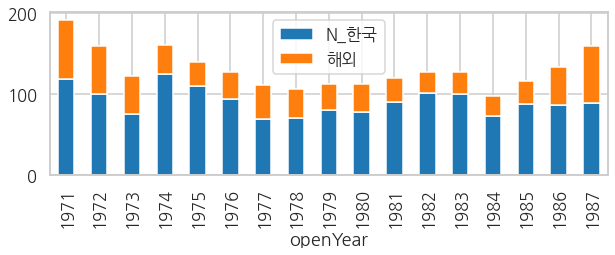

In [ ]:
# 1987년까지 영화 개봉 현황
fig, ax = plt.subplots(figsize=(10, 3))
df_nationsY.query("openYear < 1988")[["openYear", "N_한국", "해외"]].plot.bar(x="openYear", stacked=True, ax=ax)

In [ ]:
# 1988-2010 개봉 한국영화 
df_nations.query("1988 <= openYear <=2010")["N_한국"].sum()

1913

<AxesSubplot:xlabel='openYear', ylabel='N_한국'>

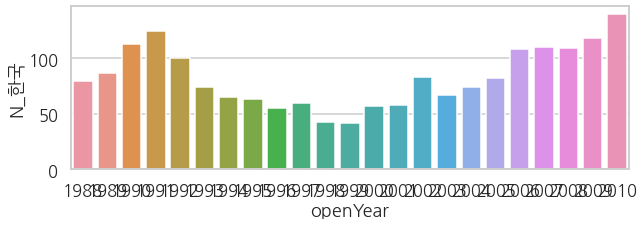

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.barplot(x="openYear", y="N_한국", data=df_nationsY.query("1988 <= openYear <=2010"), ax=ax)

In [ ]:
# 1988-2010 개봉 한국영화 연평균
df_nations.query("1988 <= openYear <=2010")["N_한국"].sum()/23

83.17391304347827

In [ ]:
# 1988-2010 개봉 해외영화 
df_nations.query("1988 <= openYear <=2010")["해외"].sum()

5932

<AxesSubplot:xlabel='openYear', ylabel='해외'>

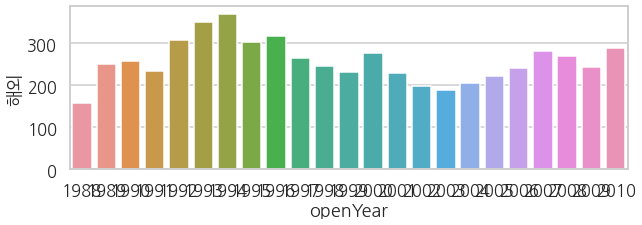

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.barplot(x="openYear", y="해외", data=df_nationsY.query("1988 <= openYear <=2010"), ax=ax)

In [ ]:
# 1988-2010 개봉 홍콩영화 
df_nations.query("1988 <= openYear <=2010")["N_홍콩"].sum()

723

<AxesSubplot:xlabel='openYear', ylabel='N_홍콩'>

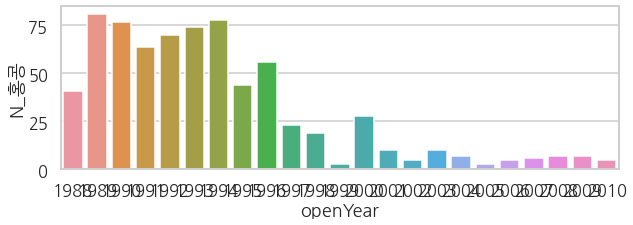

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.barplot(x="openYear", y="N_홍콩", data=df_nationsY.query("1988 <= openYear <=2010"), ax=ax)

In [ ]:
# 1988-2010 개봉 해외영화 연평균
df_nations.query("1988 <= openYear <=2010")["해외"].sum()/23

257.9130434782609

In [ ]:
# 1998년 한국영화 개봉작 수
df_nationsY.query("openYear == 1998")["N_한국"]

27    43
Name: N_한국, dtype: int64

<BarContainer object of 50 artists>

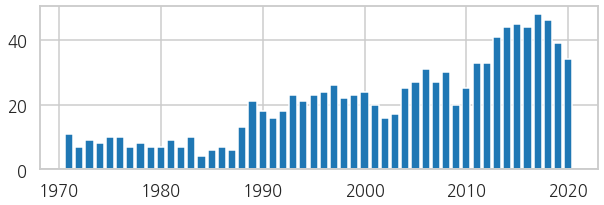

In [ ]:
# 개봉 영화 제작 국가
fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(df_nationsY["openYear"], (df_nationsY.filter(like="N_") > 0).sum(axis=1))

In [ ]:
# 전체 범위에서 가장 다양한 나라의 영화가 개봉한 해 
df_nationsY["openYear"][(df_nationsY.filter(like="N_") > 0).sum(axis=1).argmax()]

2017

In [ ]:
# 그 해에 개봉된 영화의 제작 국가 수
(df_nationsY.filter(like="N_") > 0).sum(axis=1).max()

48

In [ ]:
# 1987년 이전까지 가장 다양한 나라의 영화가 개봉됐을 때 제작 국가 수
(df_nationsY.query("openYear < 1989").filter(like="N_") > 0).sum(axis=1).max()

13

<AxesSubplot:xlabel='openYear', ylabel='N_일본'>

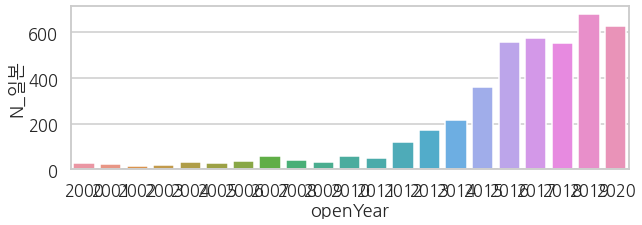

In [ ]:
# 일본영화 상영 편 수
fig, ax = plt.subplots(figsize=(10, 3))
sns.barplot(x="openYear", y="N_일본", data=df_nationsY.query("2000 <= openYear"), ax=ax)

<AxesSubplot:xlabel='openYear'>

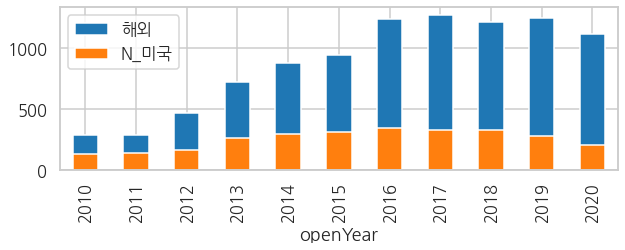

In [ ]:
# OTT 서비스 이후 해외와 미국 영화 상영 편 수
fig, ax = plt.subplots(figsize=(10, 3))
df_nationsY.query("2010 <= openYear ")[["openYear", "해외"]].plot.bar(x="openYear", ax=ax)
df_nationsY.query("2010 <= openYear ")[["openYear", "N_미국"]].plot.bar(x="openYear", ax=ax, color="C1")

<AxesSubplot:xlabel='openYear'>

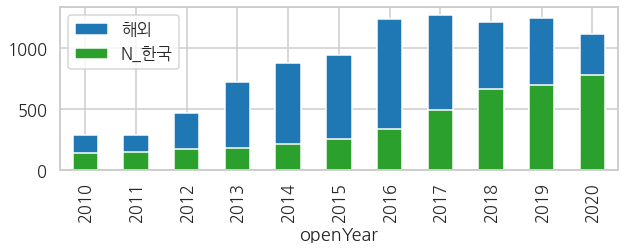

In [ ]:
# OTT 서비스 이후 해외와 한국 영화 상영 편 수
fig, ax = plt.subplots(figsize=(10, 3))
df_nationsY.query("2010 <= openYear ")[["openYear", "해외"]].plot.bar(x="openYear", ax=ax, color="C0")
df_nationsY.query("2010 <= openYear ")[["openYear", "N_한국"]].plot.bar(x="openYear", ax=ax, color="C2")

In [ ]:
# 설국열차, 미나리는 한국영화? : 미나리는 미국 영화. 2021년이라 범위 밖.
df_movielist_raw.query("movieNm == '미나리'")

,movieCd,movieNm,movieNmEn,prdtYear,openDt,typeNm,prdtStatNm,nationAlt,genreAlt,repNationNm,repGenreNm,directors,companys,openYear
294,20205144,미나리,Minari,2020,20210303,장편,개봉,미국,드라마,미국,드라마,[{'peopleNm': '정이삭'}],[],2021


In [ ]:
# 설국열차, 미나리는 한국영화? : 설국열차는 한국영화
df_nations.query("movieNm == '설국열차'")

,movieCd,movieNm,openYear,N_그리스,N_기타,N_남아프리카공화국,N_네덜란드,N_노르웨이,N_뉴질랜드,N_대만,N_덴마크,N_독일,N_러시아,N_루마니아,N_룩셈부르크,N_마케도니아,N_말레이시아,N_멕시코,N_모로코,N_몰타,N_몽고,N_미국,N_베네수엘라,N_베트남,N_벨기에,...,N_인도네시아,N_일본,N_잉글랜드,N_중국,N_체코,N_칠레,N_카자흐스탄,N_캐나다,N_콜롬비아,N_쿠바,N_크로아티아,N_태국,N_터키,N_팔레스타인,N_페루,N_포르투갈,N_폴란드,N_프랑스,N_핀란드,N_필리핀,N_한국,N_헝가리,N_호주,N_홍콩,해외
5716,20126674,설국열차,2013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### **2.2.2. 장르별 데이터셋 구축 `df_genres`**

In [ ]:
# 장르 데이터셋 구축
df_genres = df_movielist[["movieCd", "movieNm", "openYear", "genreAlt"]]
df_genres.dropna(subset=["genreAlt"], inplace=True)

# 영화 장르 파악
genres = np.unique(','.join(df_genres.loc[df_genres["genreAlt"] != ""]['genreAlt']).split(','))
genres = [g.split("(")[0] for g in genres]
print(f"{len(genres)} Genres: {genres}")

21 Genres: ['SF', '가족', '공연', '공포', '기타', '다큐멘터리', '드라마', '멜로/로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극', '성인물', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
# one-hot encoding

for genre in genres:
    df_genres[f"G_{genre}"] = df_genres["genreAlt"].str.contains(genre.split("(")[0]).astype('int')
df_genres.drop("genreAlt", axis=1, inplace=True)
df_genres.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,movieCd,movieNm,openYear,G_SF,G_가족,G_공연,G_공포,G_기타,G_다큐멘터리,G_드라마,G_멜로/로맨스,G_뮤지컬,G_미스터리,G_범죄,G_사극,G_서부극,G_성인물,G_스릴러,G_애니메이션,G_액션,G_어드벤처,G_전쟁,G_코미디,G_판타지
25540,19860079,LA용팔이,1986,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
25541,19910228,LA이야기,1991,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
25542,19870065,Y의 체험,1987,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
25696,19880146,원+씩스,1988,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26169,19910096,칙칙이의 내일은 참피온,1991,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# 기타 장르 영화 수 확인
df_genres["G_기타"].sum()

124

In [ ]:
# 아무 장르도 없는 영화를 기타로 처리
df_genres.loc[df_genres.filter(like="G_").sum(axis=1) == 0, "G_기타"] = 1
df_genres["G_기타"].sum()

305

In [ ]:
# 장르가 2개 이상인 영화를 복합장르로 지정
# 복합장르
df_genres["복합장르"] = 0
df_genres.loc[df_genres.filter(like="G_").sum(axis=1) > 1, "복합장르"] = 1

In [ ]:
# 장르 순위 데이터셋
df_genres_top21 = df_genres.filter(like="G_").sum().sort_values(ascending=False)[:21]
df_genres_top21

G_드라마       9690
G_멜로/로맨스    5860
G_액션        4451
G_코미디       3063
G_스릴러       2707
G_성인물       2091
G_공포        1465
G_범죄        1371
G_애니메이션     1164
G_어드벤처      1126
G_SF        1040
G_판타지        882
G_미스터리       699
G_다큐멘터리      659
G_가족         630
G_사극         490
G_전쟁         464
G_기타         305
G_공연         243
G_뮤지컬        161
G_서부극         91
dtype: int64

In [ ]:
# 년도별 장르 데이터셋 구축
df_genresY = df_genres[["movieCd", "openYear"]].groupby("openYear").count().reset_index().merge(df_genres.iloc[:,2:].groupby("openYear").sum().reset_index())
df_genresY.drop("movieCd", axis=1, inplace=True)
df_genresY.fillna(0, inplace=True)
df_genresY.head()

,openYear,G_SF,G_가족,G_공연,G_공포,G_기타,G_다큐멘터리,G_드라마,G_멜로/로맨스,G_뮤지컬,G_미스터리,G_범죄,G_사극,G_서부극,G_성인물,G_스릴러,G_애니메이션,G_액션,G_어드벤처,G_전쟁,G_코미디,G_판타지,복합장르
0,1971,1,3,0,4,25,3,54,51,6,2,4,12,17,0,3,0,43,8,12,14,1,53
1,1972,0,4,0,3,20,3,54,43,4,4,10,8,8,0,8,0,29,7,6,8,2,47
2,1973,0,3,0,3,8,6,38,30,4,3,12,12,1,0,6,2,28,6,6,6,2,36
3,1974,0,2,0,9,10,0,69,48,3,3,13,8,1,0,9,0,43,6,8,5,1,53
4,1975,1,3,0,7,11,2,46,42,3,2,3,8,1,0,6,0,36,8,1,8,3,35


In [ ]:
# 데이터 백업
df_genres.to_pickle("./data/df_genres.pkl")
df_genresY.to_pickle("./data/df_genresY.pkl")

#### **2.2.2.1. 한국영화 장르 데이터**

In [ ]:
# 영화 데이터
df_genres_kr = df_genres.loc[df_nations["N_한국"]==1]
df_genres_kr.head()

,movieCd,movieNm,openYear,G_SF,G_가족,G_공연,G_공포,G_기타,G_다큐멘터리,G_드라마,G_멜로/로맨스,G_뮤지컬,G_미스터리,G_범죄,G_사극,G_서부극,G_성인물,G_스릴러,G_애니메이션,G_액션,G_어드벤처,G_전쟁,G_코미디,G_판타지,복합장르
23,20201002,조제,2020,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
75,20050355,음란서생,2006,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1
105,19860031,변강쇠,1986,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1
106,19820012,애마부인,1982,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
152,20101233,평범한 날들,2011,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 년간 데이터
df_genresY_kr = df_genres_kr[["movieCd", "openYear"]].groupby("openYear").count().reset_index().merge(df_genres_kr.iloc[:,2:].groupby("openYear").sum().reset_index())
df_genresY_kr.drop("movieCd", axis=1, inplace=True)
df_genresY_kr.fillna(0, inplace=True)
df_genresY_kr.head()

,openYear,G_SF,G_가족,G_공연,G_공포,G_기타,G_다큐멘터리,G_드라마,G_멜로/로맨스,G_뮤지컬,G_미스터리,G_범죄,G_사극,G_서부극,G_성인물,G_스릴러,G_애니메이션,G_액션,G_어드벤처,G_전쟁,G_코미디,G_판타지,복합장르
0,1971,0,0,0,3,25,0,23,45,0,1,0,8,0,0,1,0,22,0,1,2,0,11
1,1972,0,0,0,2,18,0,23,34,0,2,0,6,0,0,0,0,17,0,1,3,0,6
2,1973,0,0,0,2,8,0,14,26,1,2,2,6,0,0,1,0,14,0,2,4,0,5
3,1974,0,0,0,7,9,0,46,45,1,1,0,4,0,0,1,0,27,0,3,4,0,23
4,1975,0,0,0,4,11,0,26,40,1,2,0,6,0,0,0,0,27,0,0,4,0,11


In [ ]:
# 데이터 백업
df_genres_kr.to_pickle("./data/df_genres_kr.pkl")
df_genresY_kr.to_pickle("./data/df_genresY_kr.pkl")

#### **2.2.2.2. 해외영화 장르 데이터**

In [ ]:
# 영화 데이터
df_genres_nkr = df_genres.loc[df_nations["해외"]==1]
df_genres_nkr.head()

,movieCd,movieNm,openYear,G_SF,G_가족,G_공연,G_공포,G_기타,G_다큐멘터리,G_드라마,G_멜로/로맨스,G_뮤지컬,G_미스터리,G_범죄,G_사극,G_서부극,G_성인물,G_스릴러,G_애니메이션,G_액션,G_어드벤처,G_전쟁,G_코미디,G_판타지,복합장르
10,20139221,그래비티,2013,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
27,20010264,아멜리에,2001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
52,20030039,링0 - 버스데이,2003,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
63,20050265,부에나 비스타 소셜 클럽,2001,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
73,19990317,링,1999,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1


In [ ]:
# 년간 데이터
df_genresY_nkr = df_genres_nkr[["movieCd", "openYear"]].groupby("openYear").count().reset_index().merge(df_genres_nkr.iloc[:,2:].groupby("openYear").sum().reset_index())
df_genresY_nkr.drop("movieCd", axis=1, inplace=True)
df_genresY_nkr.fillna(0, inplace=True)
df_genresY_nkr.head()

,openYear,G_SF,G_가족,G_공연,G_공포,G_기타,G_다큐멘터리,G_드라마,G_멜로/로맨스,G_뮤지컬,G_미스터리,G_범죄,G_사극,G_서부극,G_성인물,G_스릴러,G_애니메이션,G_액션,G_어드벤처,G_전쟁,G_코미디,G_판타지,복합장르
0,1971,1,3,0,1,0,3,31,6,6,1,4,4,17,0,2,0,21,8,11,12,1,42
1,1972,0,4,0,1,2,3,31,9,4,2,10,2,8,0,8,0,12,7,5,5,2,41
2,1973,0,3,0,1,0,6,24,4,3,1,10,6,1,0,5,2,14,6,4,2,2,31
3,1974,0,2,0,2,1,0,23,3,2,2,13,4,1,0,8,0,16,6,5,1,1,30
4,1975,1,3,0,3,0,2,20,2,2,0,3,2,1,0,6,0,9,8,1,4,3,24


In [ ]:
# 데이터 백업
df_genres_nkr.to_pickle("./data/df_genres_nkr.pkl")
df_genresY_nkr.to_pickle("./data/df_genresY_nkr.pkl")

#### **기초분석**

In [ ]:
# 한국 영화 편당 평균 장르 수
df_genres.filter(like="G_").sum(axis=1).loc[df_nations["N_한국"]==1].sum()/df_nations["N_한국"].sum()

1.461714747910488

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  after removing the cwd from sys.path.


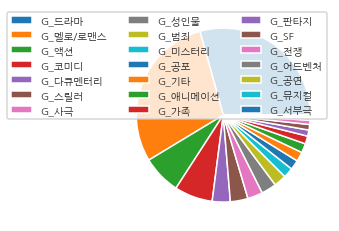

In [ ]:
# 한국 영화 장르별 비중
genres_portions_kr = df_genres.loc[df_nations["N_한국"]==1].filter(like="G_").sum().sort_values(ascending=False)/df_genres.loc[df_nations["N_한국"]==1].filter(like="G_").sum().sum()
patches, texts = plt.pie(genres_portions_kr)
plt.legend(patches, labels=genres_portions_kr.index, ncol=3, fontsize="xx-small")

In [ ]:
# 해외 영화 편당 평균 장르
df_genres.filter(like="G_").sum(axis=1).loc[df_nations["해외"]==1].sum()/df_nations["해외"].sum()

1.7390407103995997

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  after removing the cwd from sys.path.


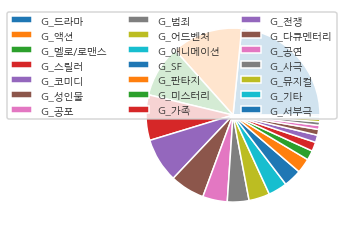

In [ ]:
# 해외 영화 장르별 비중
genres_portions_kr = df_genres.loc[df_nations["해외"]==1].filter(like="G_").sum().sort_values(ascending=False)/df_genres.loc[df_nations["해외"]==1].filter(like="G_").sum().sum()
patches, texts = plt.pie(genres_portions_kr)
plt.legend(patches, labels=genres_portions_kr.index, ncol=3, fontsize="xx-small")

In [ ]:
# 해외 영화 장르별 비중
df_genres.loc[df_nations["해외"]==1].filter(like="G_").sum().sort_values()/df_genres.loc[df_nations["해외"]==1].filter(like="G_").sum().sum()

G_서부극       0.003200
G_기타        0.004099
G_뮤지컬       0.005034
G_사극        0.006653
G_공연        0.007552
G_다큐멘터리     0.010644
G_전쟁        0.013593
G_가족        0.016937
G_미스터리      0.017836
G_판타지       0.027293
G_SF        0.033406
G_애니메이션     0.035204
G_어드벤처      0.038836
G_범죄        0.040275
G_공포        0.045705
G_성인물       0.064260
G_코미디       0.082455
G_스릴러       0.084577
G_멜로/로맨스    0.096372
G_액션        0.131972
G_드라마       0.234097
dtype: float64

In [ ]:
# 성인영화 장르가 드라마로 되어 있진 않은지: '애마부인 2016'은 성인물로 분류되지 않음.
df_genres.loc[df_genres["movieNm"].str.contains("애마")]

,movieCd,movieNm,openYear,G_SF,G_가족,G_공연,G_공포,G_기타,G_다큐멘터리,G_드라마,G_멜로/로맨스,G_뮤지컬,G_미스터리,G_범죄,G_사극,G_서부극,G_성인물,G_스릴러,G_애니메이션,G_액션,G_어드벤처,G_전쟁,G_코미디,G_판타지,복합장르
106,19820012,애마부인,1982,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
11541,20163323,애마부인 2016,2016,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17545,19910099,"겨울애마, 봄",1991,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
20448,19950019,애마와 백수건달,1995,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
20875,19940002,드라큐라 애마,1994,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
21095,19950030,애마와 변강쇠,1995,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
21537,19950039,애마부인 11,1995,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
22060,19930046,애마부인 9,1993,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
22444,19920046,애마부인 7,1992,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
23026,19930024,애마부인 8,1993,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [ ]:
# 아동용 애니메이션은 포함되어 있는지
df_genres.loc[df_genres["movieNm"].str.contains("영구")]

,movieCd,movieNm,openYear,G_SF,G_가족,G_공연,G_공포,G_기타,G_다큐멘터리,G_드라마,G_멜로/로맨스,G_뮤지컬,G_미스터리,G_범죄,G_사극,G_서부극,G_성인물,G_스릴러,G_애니메이션,G_액션,G_어드벤처,G_전쟁,G_코미디,G_판타지,복합장르
18640,19930005,영구와 공룡 쮸쮸,1993,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
20045,19908586,영구 람보,1990,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22446,19920044,영구와 흡혈귀 드라큐라,1992,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
23332,19910119,영구와 황금박쥐,1992,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
23434,19910018,영구와 땡칠이 4탄-홍콩할매귀신,1991,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
25059,19890038,영구와 땡칠이,1989,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
25060,19890083,영구와 땡칠이 소림사가다,1989,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
25061,19900090,영구와 땡칠이 3탄-영구람보,1990,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1


In [ ]:
# 아동용 애니메이션은 포함되어 있는지
df_genres.loc[df_genres["movieNm"].str.contains("우뢰매")]

,movieCd,movieNm,openYear,G_SF,G_가족,G_공연,G_공포,G_기타,G_다큐멘터리,G_드라마,G_멜로/로맨스,G_뮤지컬,G_미스터리,G_범죄,G_사극,G_서부극,G_성인물,G_스릴러,G_애니메이션,G_액션,G_어드벤처,G_전쟁,G_코미디,G_판타지,복합장르
13114,19860068,우뢰매 : 외계에서 온 우뢰매,1986,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1
19694,19860087,외계에서 온 우뢰매 2,1986,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
19695,19870044,외계에서 온 우뢰매 전격 쓰리 작전,1987,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
19696,19870085,우뢰매 4탄 썬더브이출동,1987,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
22411,19920002,우뢰매 7 : 돌아온 우뢰매,1992,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1


# **3. 데이터 시각화**

In [ ]:
# 이미지 저장 폴더
!mkdir images

## **3.1. 국가, 장르 overview**

In [ ]:
# 국가별 색상코드
c_kr = "darkblue"       # 한국
c_etc = "0.7"           # 기타, 해외
c_it = "g"              # 이탈리아
c_cn = "darkred"        # 중국
c_fr = "gold"           # 프랑스
c_hk = "orangered"      # 홍콩
c_gb = "orchid"         # 영국
c_jp = "thistle"        # 일본
c_us = "mediumpurple"   # 미국

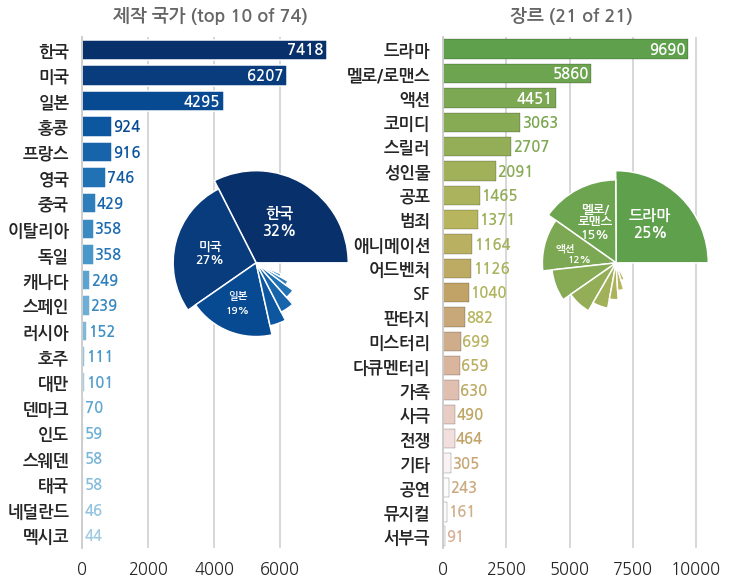

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 8), constrained_layout=True)

# 국가
blues_r = plt.get_cmap("Blues_r")
sns.barplot(x=df_nations_top20.values, y=df_nations_top20.index, ax=axs[0])
for i, p in enumerate(axs[0].patches):
    c = blues_r(i/20)
    p.set_facecolor(c)

for i, y in enumerate(df_nations_top20.index):
    val = df_nationsY[y].sum()
    if val > 2000:
        axs[0].text(val-100, i, str(val), c="w", fontsize="small", fontweight="bold", ha="right", va="center")
    else:
        axs[0].text(val+30, i, str(val), c=blues_r(i/30), fontsize="small", fontweight="bold", ha="left", va="center")

axs[0].set_yticklabels([n.split("_")[1] for n in df_nations_top20.index], fontweight="bold")
font_title = {"fontweight":"bold", "color":"0.4"}
axs[0].set_title("제작 국가 (top 10 of 74)", fontdict=font_title, pad=16)

# pie plot
ax_pie0 = fig.add_axes([0.15, 0.35, 0.4, 0.4])
ax_pie0.pie(df_nations_top20.values)
for i, (p, v) in enumerate(zip(ax_pie0.patches, df_nations_top20.values)):
    # 안수빈, 황준원, 김영도님 의견 반영하여 수정. 감사합니다 :)
    r = 1-0.1*i if i < 10 else 0
    p.set_radius(r)
    p.set_facecolor(blues_r(i/20))

ax_pie0.text(0.25, 0.3, f"한국\n{df_nations_top20['N_한국']/df_nations_top20.sum()*100:.0f}%", 
            fontsize="small", color="w", fontweight="bold", ha="center")
ax_pie0.text(-0.5, 0, f"미국\n{df_nations_top20['N_미국']/df_nations_top20.sum()*100:.0f}%", 
            fontsize="x-small", color="w", fontweight="bold", ha="center")
ax_pie0.text(-0.2, -0.38, f"일본", 
            fontsize="xx-small", color="w", fontweight="bold", ha="center")
ax_pie0.text(-0.2, -0.55, f"{df_nations_top20['N_일본']/df_nations_top20.sum()*100:.0f}%", 
            fontsize="xx-small", color="w", fontweight="bold", ha="center")
    
# 장르
gist_earth = plt.get_cmap("gist_earth")
sns.barplot(x=df_genres_top21.values, y=df_genres_top21.index, ax=axs[1])
for i, p in enumerate(axs[1].patches):
    c = gist_earth(i/35+0.5)
    p.set_facecolor(c)
    p.set_edgecolor("k")
    p.set_linewidth(0.2)

for i, y in enumerate(df_genres_top21.index):
    val = df_genres_top21[y].sum()
    if val > 4000:
        axs[1].text(val-100, i, str(val), c="w", fontsize="small", fontweight="bold", ha="right", va="center")
    else:
        axs[1].text(val+50, i, str(val), c=gist_earth(i/55+0.5), fontsize="small", fontweight="bold", ha="left", va="center")

axs[1].set_yticklabels([n.split("_")[1] for n in df_genres_top21.index], fontweight="bold")
axs[1].set_title("장르 (21 of 21)", fontdict=font_title, pad=16)

# spines
for ax in axs:
    ax.spines[["top", "right", "bottom"]].set_visible(False)

# pie plot
ax_pie1 = fig.add_axes([0.65, 0.35, 0.4, 0.4])
ax_pie1.pie(df_genres_top21.values)
for i, (p, v) in enumerate(zip(ax_pie1.patches, df_genres_top21.values)):
    r = 1 - 0.1*i if i < 10 else 0
    p.set_radius(r)
    p.set_facecolor(gist_earth(i/35+0.5))

ax_pie1.text(0.37, 0.28, f"드라마\n{df_genres_top21['G_드라마']/df_genres_top21.sum()*100:.0f}%", 
            fontsize="small", color="w", fontweight="bold", ha="center")
ax_pie1.text(-0.23, 0.27, f"멜로/\n로맨스\n{df_genres_top21['G_멜로/로맨스']/df_genres_top21.sum()*100:.0f}%", 
            fontsize="x-small", color="w", fontweight="bold", ha="center")
ax_pie1.text(-0.55, 0.13, f"액션", 
            fontsize="xx-small", color="w", fontweight="bold", ha="center")
ax_pie1.text(-0.4, 0, f"{df_genres_top21['G_액션']/df_genres_top21.sum()*100:.0f}%", 
            fontsize="xx-small", color="w", fontweight="bold", ha="center")


fig.savefig("./images/overview.png", dpi=200)

## **3.2. 한국영화 vs 해외영화 전체**

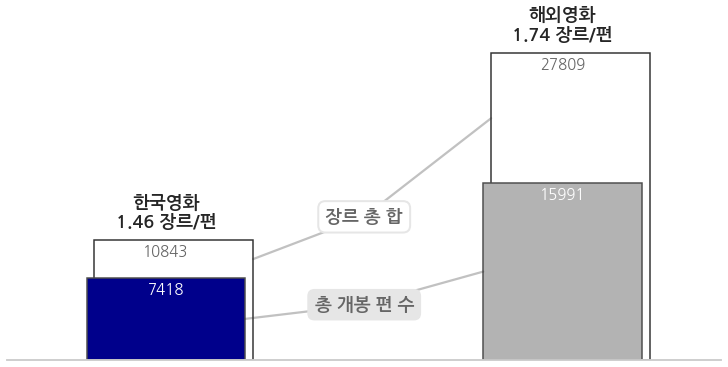

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

# 장르 수
n_genres_kr = df_genres.filter(like="G_").sum(axis=1).loc[df_nations["N_한국"]==1].sum()
n_genres_nkr = df_genres.filter(like="G_").sum(axis=1).loc[df_nations["해외"]==1].sum()
ax.bar(0.02, n_genres_kr, 
       width=0.4, fc="w", ec="0.2")
ax.bar(1.02, n_genres_nkr, 
       width=0.4, fc="w", ec="0.2")

# 영화 수
n_movies_kr = df_nations["N_한국"].sum()
n_movies_nkr = df_nations["해외"].sum()
ax.bar(0, n_movies_kr, 
       width=0.4, fc=c_kr, ec="0.3")
ax.bar(1, n_movies_nkr, 
       width=0.4, fc=c_etc, ec="0.3")

# text
offset = 300
ax.text(0, n_genres_kr-offset, n_genres_kr, 
        fontsize="small", ha="center", va="top", color="0.4")
ax.text(1, n_genres_nkr-offset, n_genres_nkr, 
        fontsize="small", ha="center", va="top", color="0.4")
ax.text(0, n_movies_kr-offset, n_movies_kr, 
        fontsize="small", ha="center", va="top", color="w")
ax.text(1, n_movies_nkr-offset, n_movies_nkr, 
        fontsize="small", ha="center", va="top", color="w")

ax.text(0, n_genres_kr+offset*3, f"한국영화\n{n_genres_kr/n_movies_kr:.2f} 장르/편", 
        fontweight="bold", ha="center", va="bottom")
ax.text(1, n_genres_nkr+offset*3, f"해외영화\n{n_genres_nkr/n_movies_nkr:.2f} 장르/편", 
        fontweight="bold", ha="center", va="bottom")

# legend
p = 0.7
ax.text(0.5, p*n_movies_kr/2 + (1-p)*n_movies_nkr/2, 
        "총 개봉 편 수", color="0.4", fontweight="bold", ha="center", va="center", zorder=2, 
        bbox={"boxstyle":"round", "pad":0.4, 
                      "facecolor":'0.9', "edgecolor":'none', "linewidth":0})
ax.text(0.5, p*((n_genres_kr-n_movies_kr)/2 + n_movies_kr) + (1-p)*((n_genres_nkr-n_movies_nkr)/2 + n_movies_nkr), 
        "장르 총 합", color="0.4", fontweight="bold", ha="center", va="center", zorder=2, 
        bbox={"boxstyle":"round", "pad":0.4, 
                      "facecolor":'w', "edgecolor":'0.9', "linewidth":2})
ax.plot([0.2, 0.5, 0.8], 
        [n_movies_kr/2, p*n_movies_kr/2 + (1-p)*n_movies_nkr/2, n_movies_nkr/2], 
        c="0.2", alpha=0.3)
ax.plot([0.22, 0.5, 0.82], 
        [(n_genres_kr-n_movies_kr)/2 + n_movies_kr, 
         p*((n_genres_kr-n_movies_kr)/2 + n_movies_kr) + (1-p)*((n_genres_nkr-n_movies_nkr)/2 + n_movies_nkr), 
         (n_genres_nkr-n_movies_nkr)/2 + n_movies_nkr], 
        c="0.2", alpha=0.3)

ax.spines[["left", "top", "right"]].set_visible(False)
ax.set_xlim(-0.4, 1.4)
ax.set_xticks([0, 1])
ax.set_xticklabels([])
ax.set_yticks([])
# ax.set_yticks([0, 10000, 20000, 30000])
ax.grid(axis="x")

fig.savefig("./images/genres_movie_ratio.png", dpi=200)

## **3.3. 년도별 제작국가**

[Text(0, 0, '0'), Text(1, 0, '100%')]

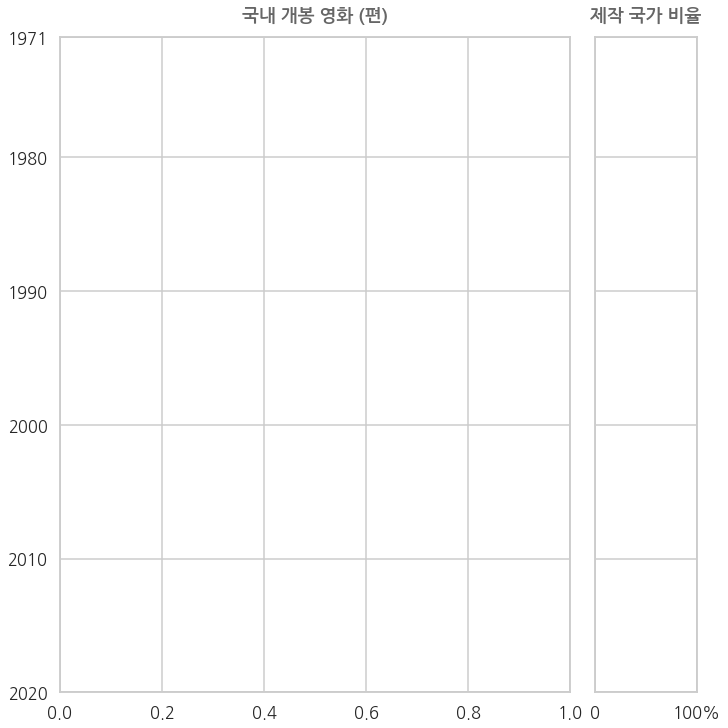

In [ ]:
# 틀 만들기
fig, axs = plt.subplots(ncols=2, gridspec_kw={"width_ratios":[5,1]},
                        sharey=True,
                        figsize=(10, 10), constrained_layout=True)

axs[0].set_title("국내 개봉 영화 (편)", fontdict=font_title, pad=16)
axs[1].set_title("제작 국가 비율", fontdict=font_title, pad=16)

portion_aspect0 = axs[0].get_position().height/axs[0].get_position().width
portion_aspect1 = axs[1].get_position().height/axs[1].get_position().width
portion_aspect0

yticks = [1971, 1980, 1990, 2000, 2010, 2020]
axs[0].set_ylim(2020, 1971)
axs[0].set_yticks(yticks)
axs[0].set_yticklabels(yticks)

axs[1].set_xticks([0, 1])
axs[1].set_xticklabels([0, "100%"])

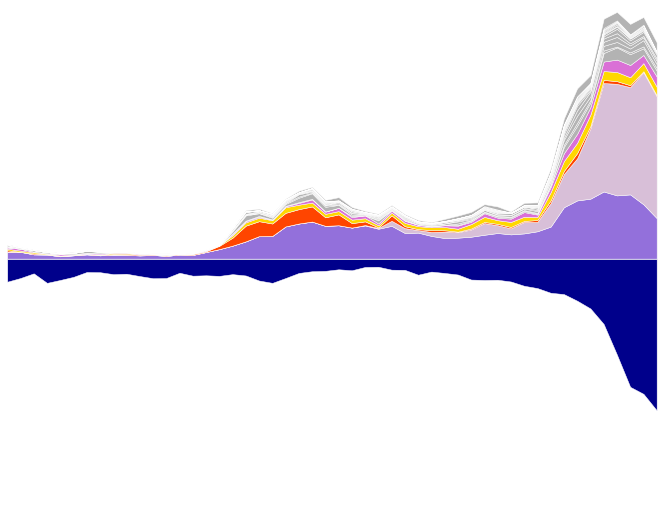

In [ ]:
# 국내 개봉 영화 편 수

fig_p0, ax_p0 = plt.subplots(figsize=(axs[0].get_position().height * 10, axs[0].get_position().width * 10), constrained_layout=True)

ax_p0.stackplot(df_nationsY["openYear"], -df_nationsY["N_한국"], colors=c_kr, ec="w", lw=0.5)
ax_p0.stackplot(df_nationsY["openYear"], df_nationsY["해외"], colors=c_etc, ec="w", lw=0.5)

nationsY_top20_foreign = []
for n in df_nations_top20.index[1:]:
    nationsY_top20_foreign.append(df_nationsY[f'{n}'])

ax_p0.stackplot(df_nationsY["openYear"],
                nationsY_top20_foreign, 
                colors=[c_us, c_jp, c_hk, c_fr, c_gb] + [c_etc]*14, ec="w", lw=0.5)

ax_p0.set_ylim(-1300, 1300)
ax_p0.set_xlim(1971, 2020)
ax_p0.axis(False)

fig_p0.savefig("./images/portion_year0.png", dpi=200, pad_inches=0)

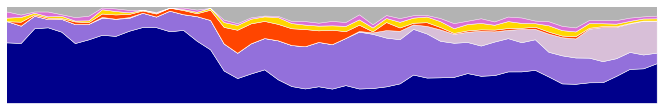

In [ ]:
# 영화 편 수 비율
fig_p, ax_p = plt.subplots(figsize=(axs[1].get_position().height * 10, axs[1].get_position().width * 10), constrained_layout=True)

ax_p.stackplot(df_nationsY.index, 
               df_nationsY["N_한국"]/df_nationsY.filter(like="N_").sum(axis=1), 
               df_nationsY["N_미국"]/df_nationsY.filter(like="N_").sum(axis=1), 
               df_nationsY["N_일본"]/df_nationsY.filter(like="N_").sum(axis=1), 
               df_nationsY["N_홍콩"]/df_nationsY.filter(like="N_").sum(axis=1), 
               df_nationsY["N_프랑스"]/df_nationsY.filter(like="N_").sum(axis=1), 
               df_nationsY["N_영국"]/df_nationsY.filter(like="N_").sum(axis=1), 
             colors=[c_kr, c_us, c_jp, c_hk, c_fr, c_gb], ec="w", lw=0.5)
ax_p.set_facecolor(c_etc)
ax_p.set_xlim(1, df_nationsY.shape[0]-1)
ax_p.set_ylim(0, 1)
ax_p.set_xticks([])
ax_p.set_yticks([])
ax_p.spines[["top", "bottom", "left", "right"]].set_visible(False)
fig_p.savefig("./images/portion_year1.png", dpi=200, pad_inches=0)

In [ ]:
# 역사적 사건들 
def plot_history(year, text, text_x_shift=50, text_y=None, text_c="green", text_size="x-small", text_fc="w", text_align="center",
                 c_h0 = "limegreen", c_h1 = "palegreen", alpha_h1=0.7, ax=axs):
    if not text_y:
        text_y = year-0.5
    
    y_line = [year] * 100
    
    if np.array(axs == None).any():
        ax = plt.gca()
        x0_line = np.linspace(ax.get_xbound()[1], ax.get_xbound()[0], 100)
        x1_line = 0
        ax_0 = ax
    elif isinstance(ax, np.ndarray):
        x0_line = np.linspace(axs[0].get_xbound()[1], axs[0].get_xbound()[0], 100)
        x1_line = np.linspace(axs[1].get_xbound()[1], axs[1].get_xbound()[0], 100)
        ax_0 = ax[0]
    else:
        x0_line = np.linspace(axs[0].get_xbound()[1], axs[0].get_xbound()[0], 100)
        x1_line = 0
        ax_0 = ax
    
    # axs[0]
    for i in range(99):
        ax_0.plot(x0_line[i:i+2], y_line[i:i+2], c=c_h0,
                    solid_capstyle='butt', alpha=np.power(np.sin(i/100),6)*2, zorder=15)
    ax_0.text(ax_0.get_xbound()[0]+text_x_shift, text_y, text, c=text_c, fontsize=text_size, 
              multialignment=text_align, ha="left",
              bbox={"boxstyle":"square", "pad":0.4, "facecolor":text_fc, "edgecolor":"none", "linewidth":1})  
    
    # axs[1:]
    if isinstance(x1_line, np.ndarray):
        for ax_ in ax[1:]:
            for i in range(99):
                ax_.plot(x1_line[i:i+2], y_line[i:i+2], c=c_h1,
                         solid_capstyle='butt', alpha=alpha_h1, zorder=15)

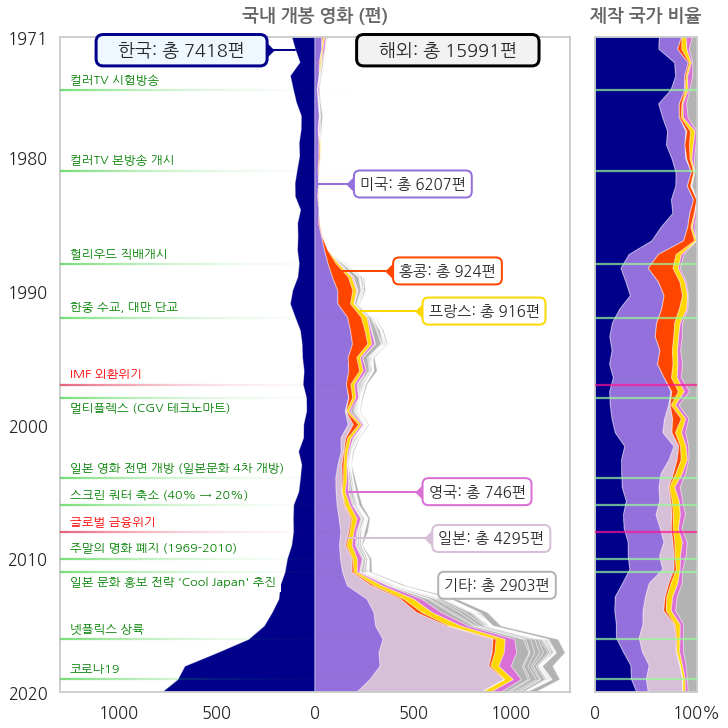

In [ ]:
## 조립

# axs[0]
fig0_img = plt.imread("./images/portion_year0.png")
fig0_img = fig0_img.swapaxes(0, 1)[:,::-1, :][10:-10,10:-10,:]
x0, x1 = -1300, 1300
y1, y0 = 1971, 2020

axs[0].imshow(fig0_img, extent=[x0, x1, y0, y1])
axs[0].set_aspect(abs(x1-x0)/abs(y1-y0)*portion_aspect0)

xticks = [-1000, -500, 0, 500, 1000]
axs[0].set_xticks(xticks)
axs[0].set_xticklabels([abs(x) for x in xticks])
for y in yticks:
    axs[0].axhline(y, c="lightgray", alpha=0.2, zorder=-1)

axs[0].grid(False)

# plot_stem
def plot_stem(x, y, x0=0, s=100, ls="-", lw=2, c="cyan", marker="D", 
              text="sample", text_size="small", position="right", bbox_lw=2, bbox_fc="w", ax=None, **kwargs):
    ax.plot([x0, x], [y, y], ls=ls, lw=lw, c=c)
    ax.scatter(x, y, s=s, c=c, marker=marker, **kwargs)
    if text:
        offset = 30
        text_pos = x+offset if position == "right" else x-offset
        ha = "left" if position == "right" else "right"
        va = "center"
        ax.text(text_pos, y, text, ha=ha, va=va, fontsize=text_size,
                bbox={"boxstyle":"round", "pad":0.4, 
                      "facecolor":bbox_fc, "edgecolor":c, "linewidth":bbox_lw}, 
                zorder=20)

### Legends
handles, labels = axs[0].get_legend_handles_labels()

# 한국
plot_stem(-250, 1972, x0=-100, c=c_kr, bbox_lw=3, text=f"   한국: 총 {df_nations['N_한국'].sum()}편   ", 
          text_size="medium", bbox_fc="aliceblue", position="left", ax=axs[0])

# 미국
plot_stem(200, 1982, x0=10, c=c_us, text=f"미국: 총 {df_nations_top20['N_미국']}편", ax=axs[0])

# 일본
plot_stem(600, 2008.5, x0=170, c=c_jp, text=f"일본: 총 {df_nations_top20['N_일본']}편", ax=axs[0])

# 프랑스
plot_stem(550, 1991.5, x0=220, c=c_fr, text=f"프랑스: 총 {df_nations_top20['N_프랑스']}편", ax=axs[0])

# 홍콩
plot_stem(400, 1988.5, x0=95, c=c_hk, text=f"홍콩: 총 {df_nations_top20['N_홍콩']}편", ax=axs[0])

# 영국
plot_stem(550, 2005, x0=170, c=c_gb, text=f"영국: 총 {df_nations_top20['N_영국']}편", ax=axs[0])

# 기타
plot_stem(630, 2012, x0=630, c=c_etc, text=f"기타: 총 {df_nations['해외'].sum()-df_nations_top20.iloc[1:6].sum()}편", 
          s=0, ax=axs[0])

axs[0].text(250, 1972, f"   해외: 총 {df_nations['해외'].sum()}편   ", ha="left", va="center",
            bbox={"boxstyle":"round", "pad":0.4, 
                  "facecolor":"0.95", "edgecolor":"k", "linewidth":3}, 
            zorder=20)

# axs[1]
fig1_img = plt.imread("./images/portion_year1.png")
fig1_img = fig1_img.swapaxes(0, 1)[:,::-1, :][10:-10,10:-10,:]
x0, x1 = 0, 1
y1, y0 = 1971, 2020

axs[1].imshow(fig1_img, extent=[x0, x1, y0, y1])
axs[1].set_aspect(abs(x1-x0)/abs(y1-y0)*portion_aspect1)
axs[1].grid(False)


# 컬러TV 방송
plot_history(1975, "컬러TV 시험방송")
plot_history(1981, "컬러TV 본방송 개시")

# 헐리우드 직배영화
plot_history(1988, "헐리우드 직배개시")

# 한중수교
plot_history(1992, "한중 수교, 대만 단교")

# IMF
plot_history(1997, "IMF 외환위기", text_c="r", c_h0="crimson", c_h1="deeppink")

# 멀티플렉스
plot_history(1998, "멀티플렉스 (CGV 테크노마트)", text_y=1999)

# 일본 영화 전면 개방
plot_history(2004, "일본 영화 전면 개방 (일본문화 4차 개방)")

# 스크린쿼터
plot_history(2006, "스크린 쿼터 축소 (40% → 20%)")

# 글로벌 금융위기
plot_history(2008, "글로벌 금융위기", text_c="r", c_h0="crimson", c_h1="deeppink")

# 주말의 명화 폐지
plot_history(2010, "주말의 명화 폐지 (1969-2010)")

# 일본 쿨 재팬 전략
plot_history(2011, "일본 문화 홍보 전략 'Cool Japan' 추진", text_y=2012)

# 넷플릭스 상륙
plot_history(2016, "넷플릭스 상륙")

# 코로나19
plot_history(2019, "코로나19")

axs[1].set_xlim(0, 1)

fig.savefig("./images/num_year.png", dpi=200)
display(fig)

## **3.4. 년도별 장르**

In [ ]:
# 기타 제외
genres_noetc = [g.split("_")[1] for g in df_genres_top21.index if "기타" not in g]
genres_noetc

['드라마',
 '멜로/로맨스',
 '액션',
 '코미디',
 '스릴러',
 '성인물',
 '공포',
 '범죄',
 '애니메이션',
 '어드벤처',
 'SF',
 '판타지',
 '미스터리',
 '다큐멘터리',
 '가족',
 '사극',
 '전쟁',
 '공연',
 '뮤지컬',
 '서부극']

In [ ]:
# 장르별 색상
cmap = plt.get_cmap("tab20")

c_drama = cmap(0/20)        # 드라마
c_romance = cmap(1/20)      # 멜로/로맨스
c_action = cmap(2/20)       # 액션
c_comedy = cmap(3/20)       # 코미디
c_thriller = cmap(12/20)    # 스릴러
c_ero = cmap(13/20)         # 성인물
c_horror = cmap(6/20)       # 공포
c_crime = cmap(7/20)        # 범죄
c_ani = cmap(8/20)          # 애니메이션
c_adv = cmap(9/20)          # 어드벤처
c_sf = cmap(10/20)          # SF
c_fantasy = cmap(11/20)     # 판타지
c_mistery = cmap(4/20)      # 미스터리
c_docu = cmap(5/20)         # 다큐멘터리
c_family = cmap(14/20)      # 가족
c_history = cmap(15/20)     # 사극
c_war = cmap(16/20)         # 전쟁
c_play = cmap(17/20)        # 공연
c_musical = cmap(18/20)     # 뮤지컬
c_western = cmap(19/20)     # 서부극

c_genres = [c_drama, c_romance, c_action, c_comedy, c_thriller, c_ero, c_horror, c_crime, c_ani, c_adv, c_sf, c_fantasy, c_mistery, c_docu, c_family, c_history, c_war, c_play, c_musical, c_western, c_etc]

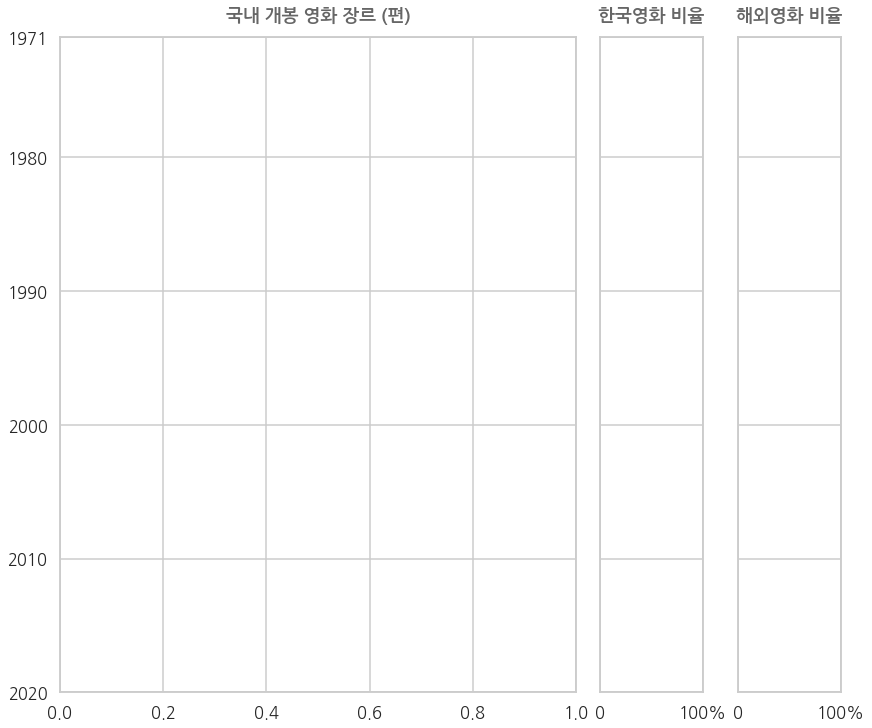

In [ ]:
# 틀 만들기
fig, axs = plt.subplots(ncols=3, gridspec_kw={"width_ratios":[5,1,1]},
                        sharey=True,
                        figsize=(12, 10), constrained_layout=True)

axs[0].set_title("국내 개봉 영화 장르 (편)", fontdict=font_title, pad=16)
axs[1].set_title("한국영화 비율", fontdict=font_title, pad=16)
axs[2].set_title("해외영화 비율", fontdict=font_title, pad=16)

portion_aspect0 = axs[0].get_position().height/axs[0].get_position().width
portion_aspect1 = axs[1].get_position().height/axs[1].get_position().width
portion_aspect2 = axs[2].get_position().height/axs[2].get_position().width

yticks = [1971, 1980, 1990, 2000, 2010, 2020]
axs[0].set_ylim(2020, 1971)
axs[0].set_yticks(yticks)
axs[0].set_yticklabels(yticks)

for ax in axs[1:]:
    ax.set_xticks([0, 1])
    ax.set_xticklabels([0, "100%"])


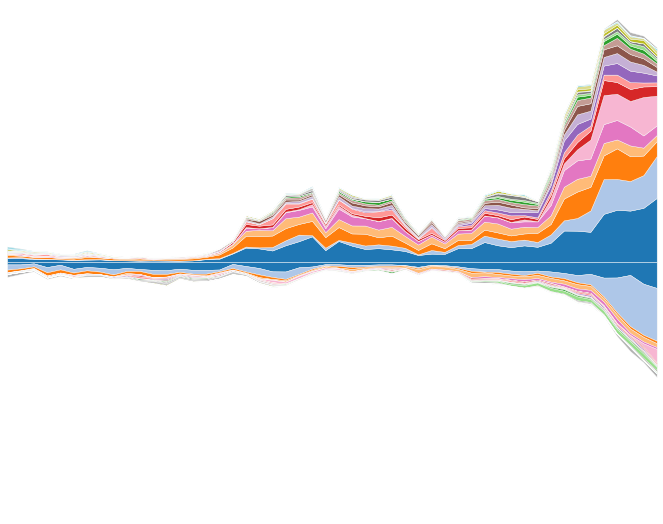

In [ ]:
# 년도별 장르
sns.set_palette("tab20")

fig_p0, ax_p0 = plt.subplots(figsize=(axs[0].get_position().height * 10, axs[0].get_position().width * 12), constrained_layout=True)

stack_ys_kr = []
stack_ys_nkr = []
for g in genres_noetc:
    stack_ys_kr.append(eval(f"-df_genresY_kr['G_{g}']"))
    stack_ys_nkr.append(eval(f"df_genresY_nkr['G_{g}']"))
    
ax_p0.stackplot(df_genresY_kr["openYear"], *stack_ys_kr, 
                 ec="w", lw=0.4, colors=c_genres[:20])
ax_p0.stackplot(df_genresY_nkr["openYear"], *stack_ys_nkr, 
                 ec="w", lw=0.4, colors=c_genres[:20])

# G_기타
ax_p0.stackplot(df_genresY_kr["openYear"], 
                -df_genresY_kr.filter(like="G_").sum(axis=1), 
                ec="w", lw=0.4, zorder=-1)
ax_p0.stackplot(df_genresY_nkr["openYear"], 
                df_genresY_nkr.filter(like="G_").sum(axis=1), 
                ec="w", lw=0.4, zorder=-1)
ax_p0.get_children()[40].set_facecolor(c_etc)
ax_p0.get_children()[41].set_facecolor(c_etc)

ax_p0.set_xlim(1971, 2020)
ax_p0.set_ylim(-2200, 2200)
ax_p0.axis(False)
fig_p0.savefig("./images/genres_year0.png")

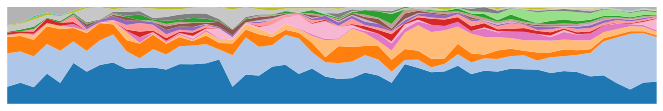

In [ ]:
# 한국영화 장르 비율

stack_ys_kr.append(-df_genresY_kr['G_기타'])

stack_ys_kr_p = np.array(stack_ys_kr)/np.array(stack_ys_kr).sum(axis=0)
stack_ys_kr_p.shape

fig_p1, ax_p1 = plt.subplots(figsize=(axs[1].get_position().height * 10, axs[1].get_position().width * 12), constrained_layout=True)

ax_p1.stackplot(df_genresY_kr["openYear"], *stack_ys_kr_p, colors=c_genres,
               ec="none", lw=0.5)
ax_p1.get_children()[20].set_facecolor(c_etc)
ax_p1.set_xlim(1971, 2020)
ax_p1.set_ylim(0, 1)
ax_p1.set_xticks([])
ax_p1.set_yticks([])
ax_p1.spines[["top", "bottom", "left", "right"]].set_visible(False)
fig_p1.savefig("./images/genres_year1.png", dpi=200)

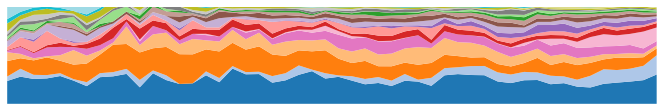

In [ ]:
# 해외영화 장르 비율

stack_ys_nkr.append(-df_genresY_nkr['G_기타'])

stack_ys_nkr_p = np.array(stack_ys_nkr)/np.array(stack_ys_nkr).sum(axis=0)
stack_ys_nkr_p.shape

fig_p2, ax_p2 = plt.subplots(figsize=(axs[2].get_position().height * 10, axs[2].get_position().width * 12), constrained_layout=True)

ax_p2.stackplot(df_genresY_nkr["openYear"], *stack_ys_nkr_p, colors=c_genres,
               ec="none", lw=0.5)
ax_p2.get_children()[20].set_facecolor(c_etc)
ax_p2.set_xlim(1971, 2020)
ax_p2.set_ylim(0, 1)
ax_p2.set_xticks([])
ax_p2.set_yticks([])
ax_p2.spines[["top", "bottom", "left", "right"]].set_visible(False)
fig_p2.savefig("./images/genres_year2.png", dpi=200)

## **3.5. 국내 개봉작 장르 비율**

In [ ]:
#국가별 상위 장르
# 1. 한국
idx_movies_kr = df_nations.query("N_한국 == 1")[["movieCd", "movieNm", "openYear"]].index
genres_portion_kr = df_genres.loc[idx_movies_kr].filter(like="G_").sum().sort_values(ascending=True)/len(idx_movies_kr)
genres_portion_kr_idx = genres_portion_kr.index
genres_portion_kr_v = genres_portion_kr.values

# 2. 미국
idx_movies_us = df_nations.query("N_미국 == 1")[["movieCd", "movieNm", "openYear"]].index
genres_portion_us = df_genres.loc[idx_movies_us].filter(like="G_").sum().sort_values(ascending=True)/len(idx_movies_us)
genres_portion_us_v = genres_portion_us.loc[genres_portion_kr_idx]

# 3. 일본
idx_movies_jp = df_nations.query("N_일본 == 1")[["movieCd", "movieNm", "openYear"]].index
genres_portion_jp = df_genres.loc[idx_movies_jp].filter(like="G_").sum().sort_values(ascending=True)/len(idx_movies_jp)
genres_portion_jp_v = genres_portion_jp.loc[genres_portion_kr_idx]

# 4. 홍콩
idx_movies_hk = df_nations.query("N_홍콩 == 1")[["movieCd", "movieNm", "openYear"]].index
genres_portion_hk = df_genres.loc[idx_movies_hk].filter(like="G_").sum().sort_values(ascending=True)/len(idx_movies_hk)
genres_portion_hk_v = genres_portion_hk.loc[genres_portion_kr_idx]

# 5. 프랑스
idx_movies_fr = df_nations.query("N_프랑스 == 1")[["movieCd", "movieNm", "openYear"]].index
genres_portion_fr = df_genres.loc[idx_movies_fr].filter(like="G_").sum().sort_values(ascending=True)/len(idx_movies_fr)
genres_portion_fr_v = genres_portion_fr.loc[genres_portion_kr_idx]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


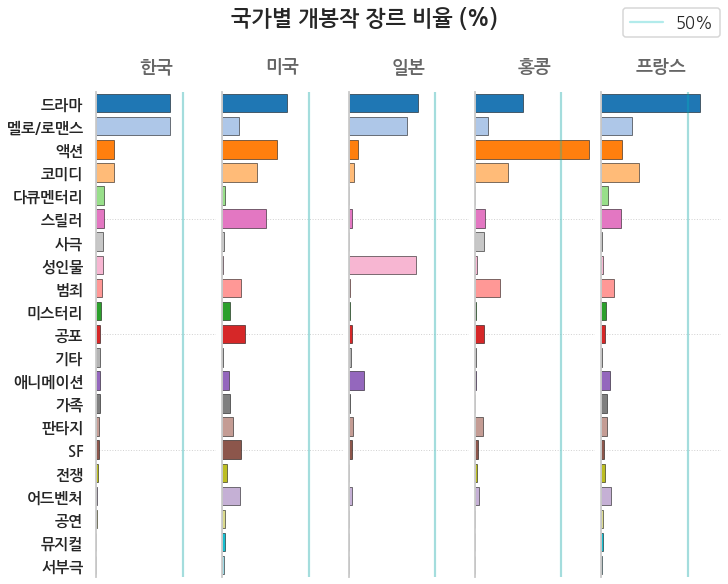

In [ ]:
fig, axs = plt.subplots(ncols=5, figsize=(10, 8), constrained_layout=True, sharey=True, sharex=True)

for ax, n, c, p in zip(axs, 
                       ["한국", "미국", "일본", "홍콩", "프랑스"], 
                       [c_kr, c_us, c_jp, c_hk, c_fr],
                       [genres_portion_kr_v, genres_portion_us_v, genres_portion_jp_v, genres_portion_hk_v, genres_portion_fr_v]):
    ax.barh(genres_portion_kr_idx, p, 
            color=[c_western, c_musical, c_play, c_adv, c_war, c_sf, c_fantasy, 
                   c_family, c_ani, c_etc, c_horror, c_mistery, c_crime, c_ero, 
                   c_history, c_thriller, c_docu, c_comedy, c_action, c_romance, c_drama],
            height=0.8, ec="k", lw=0.5)
    
    ax.spines[["top", "right", "bottom"]].set_visible(False)
    
    ax.grid(axis="y", alpha=0)
    ax.grid(axis="x", alpha=0.5)
    ax.axvline(0.5, c="c", alpha=0.3)
    ax.tick_params(color="w")
    
    xbound = ax.get_xbound()
    xticks = [x for x in np.linspace(0, 1, 3) if xbound[0] <= x <= xbound[1]]
    ax.set_xticks(xticks)
    ax.set_xticklabels([])
    yticklabels = [g.split("_")[1] for g in genres_portion_kr_idx]
    ax.set_yticklabels(yticklabels, size="small", fontweight="bold")
    
    ax.set_title(n, fontdict=font_title, pad=20)
    
    for y in [5, 10, 15]:
        ax.axhline(y, c="lightgray", ls=":", lw=1, zorder=-1)
    
axs[0].set_ylim(-0.5, len(genres_portion_kr)-0.5)
fig.legend(handles=[ax.get_children()[21]], labels=["50%"])
fig.suptitle("국가별 개봉작 장르 비율 (%)\n", fontweight="bold")
fig.savefig("./images/genres_movie_ratio_nations.png", dpi=200)

## **3.6. 시기별 대표 장르**

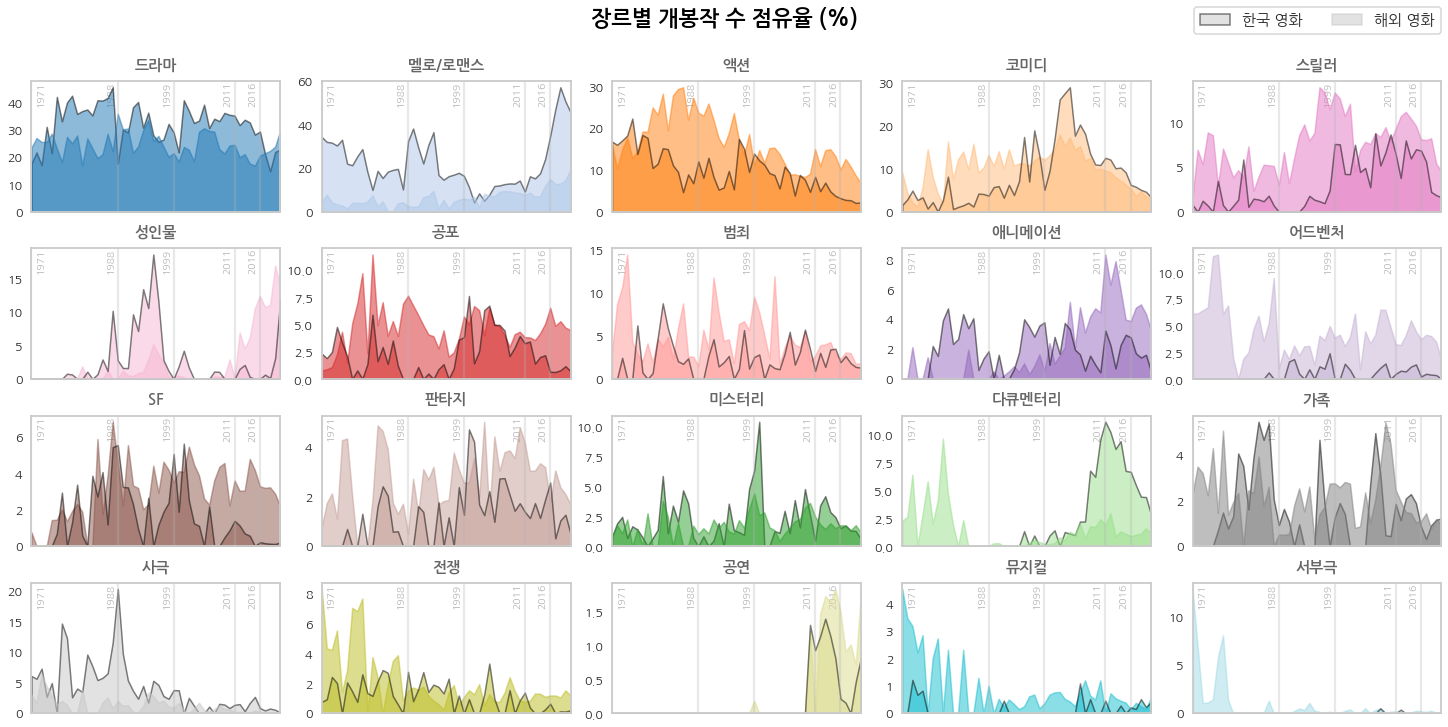

In [ ]:
# 장르별 흐름
fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(20, 10), sharex=True, constrained_layout=True)
axs = axes.ravel()

z_krs = [1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2]

genres_order = genres_noetc + ["기타"]
for g, ax, c, z_kr in zip(genres_order[:20], axs, c_genres[:20], z_krs):
    genre_kr = df_genresY_kr[f"G_{g}"]/df_genresY_kr.filter(like="G_").sum(axis=1)
    genre_nkr = df_genresY_nkr[f"G_{g}"]/df_genresY_nkr.filter(like="G_").sum(axis=1)
    z_nkr = 2 if z_kr == 1 else 1
    
    ax.fill_between(df_genresY_kr["openYear"], 
            genre_kr * 100, 0,
            fc=c, ec="k", alpha=0.5, label="한국 영화", zorder=z_kr)
    ax.fill_between(df_genresY_nkr["openYear"], 
            genre_nkr * 100, 0,
            fc=c, ec=c, alpha=0.5, label="해외 영화", zorder=z_nkr)
#     ax.text(2000, 0, g, ha="center")
    ax.set_title(g, fontdict=font_title, fontsize="small", pad=12)
    ax.set_xlim(1971, 2020)
    ax.set_ylim(0, )
    years = [1971, 1988, 1999, 2011, 2016]
    for year in years:
        ax.axvline(year, alpha=0.3, c=c_etc)
        text_x = year-0.5 if year!= 1971 else year+1
        ha = "right" if year != 1971 else "left"
        ax.text(text_x, ax.get_ybound()[1], year, va="top", ha=ha, fontsize="xx-small", c=c_etc, rotation=90, zorder=-1)
    ax.set_xticks(years)
    ax.set_xticklabels([])
    ax.grid(False)    
    ax.tick_params(labelsize="x-small", pad=0)
    
### label
handles, labels = axs[15].get_legend_handles_labels()
fig.legend(handles=handles[:2], labels=labels[:2], fontsize="small", ncol=2)
    
fig.suptitle("장르별 개봉작 수 점유율 (%)\n", fontweight="bold",  color="k")
fig.savefig("./images/genres_separate.png", dpi=200)

## **3.7. 국가별 시기별 개봉 장르**

### **3.7.1. 데이터 & 시각화 함수**

In [ ]:
# 국가별 장르 분할

# 미국
df_genres_us = df_genres.loc[df_nations["N_미국"]==1]
df_genresY_us = df_genres_us[["movieCd", "openYear"]].groupby("openYear").count().reset_index().merge(df_genres_us.iloc[:,2:].groupby("openYear").sum().reset_index())
df_genresY_us.drop("movieCd", axis=1, inplace=True)
df_genresY_us.fillna(0, inplace=True)
df_genresY_us["openYear"] = df_genresY_us["openYear"].astype(int)

# 일본
df_genres_jp = df_genres.loc[df_nations["N_일본"]==1]
df_genresY_jp = df_genres_jp[["movieCd", "openYear"]].groupby("openYear").count().reset_index().merge(df_genres_jp.iloc[:,2:].groupby("openYear").sum().reset_index())
df_genresY_jp.drop("movieCd", axis=1, inplace=True)
df_genresY_jp.fillna(0, inplace=True)
df_genresY_jp["openYear"] = df_genresY_jp["openYear"].astype(int)

# 홍콩
df_genres_hk = df_genres.loc[df_nations["N_홍콩"]==1]
df_genresY_hk = df_genres_hk[["movieCd", "openYear"]].groupby("openYear").count().reset_index().merge(df_genres_hk.iloc[:,2:].groupby("openYear").sum().reset_index())
df_genresY_hk.drop("movieCd", axis=1, inplace=True)
df_genresY_hk.fillna(0, inplace=True)
df_genresY_hk["openYear"] = df_genresY_hk["openYear"].astype(int)

# 프랑스
df_genres_fr = df_genres.loc[df_nations["N_프랑스"]==1]
df_genresY_fr = df_genres_fr[["movieCd", "openYear"]].groupby("openYear").count().reset_index().merge(df_genres_fr.iloc[:,2:].groupby("openYear").sum().reset_index())
df_genresY_fr.drop("movieCd", axis=1, inplace=True)
df_genresY_fr.fillna(0, inplace=True)
df_genresY_fr["openYear"] = df_genresY_fr["openYear"].astype(int)

In [ ]:
# 최다 5개 국가
N_top5 = ["한국", "미국", "일본", "홍콩", "프랑스"]

In [ ]:
# 장르별 색상
G_colors = dict(zip([f"G_{g}" for g in genres_order], c_genres))

In [ ]:
# 시각화 함수

def plot_time_GN_(nation, times, ax, genres=[], topN=3):
    time_init = times[0]
    time_fin = times[1]
    
    if nation == "한국":
        df = df_genresY_kr
    elif nation == "미국":
        df = df_genresY_us
    elif nation == "일본":
        df = df_genresY_jp
    elif nation == "홍콩":
        df = df_genresY_hk
    elif nation == "프랑스":
        df = df_genresY_fr
        
    # openYear 결측치 메우기
    year_zero = list(set(range(1971, 2021)) - set(df["openYear"].values))
    data_zero = np.zeros((len(year_zero), 23))
    data_zero[:,0] = year_zero
    df_zero = pd.DataFrame(data=data_zero, columns=df_genresY_jp.columns)
    df_zero["openYear"] = df_zero["openYear"].astype(int)
    df = pd.concat([df, df_zero], axis=0).sort_values("openYear").reset_index()
    
    # 국가별, 장르별 데이터 정리
    df_nationsY_time = df_nationsY.query(f"{time_init} <= openYear <= {time_fin}")
    df_genresY_ntime = df.query(f"{time_init} <= openYear <= {time_fin}")
    G_sort = df_genresY_ntime.filter(like="G_").sum().sort_values(ascending=False)
    G_sort_top = G_sort[:topN]
    
    if len(genres) == 0:
        G_names = list(G_sort_top.index)
        G_counts = list(G_sort_top.values)
    else:
        G_names = genres
        G_counts = G_sort.loc[genres].values

    # 해당 국가 개봉 편 수
    ax.plot(df_nationsY_time["openYear"], df_nationsY_time[f"N_{nation}"], 
            c="k", lw=2, zorder=10, label="개봉 편 수")
    ax.stackplot(df_genresY_ntime["openYear"], [df_genresY_ntime[g] for g in G_names],
                 colors=[G_colors[g] for g in G_names], ec="w", lw=0.5, zorder=5, 
                 labels=[f"{g.split('_')[1]}: {int(c)}" for g, c in zip(G_names, G_counts)])
    ax.set_xlim(times)
    ax.set_ylim(0, )
    ax.grid(False)
    ax.spines[["top", "right"]].set_visible(False)
    ax.set_ylabel(nation, fontdict=font_title, rotation=0, ha="right", va="center")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels= labels[1:], fontsize="xx-small",
              loc="upper left", bbox_to_anchor=(1, 1), ncol=1)
    
    return handles, labels


def plot_time_GN(time_init, time_fin, topN=3):
    fig, axs = plt.subplots(nrows=5, figsize=(10, 7), constrained_layout=True, sharex=True)
    for N, ax in zip(N_top5, axs):
        handles, labels = plot_time_GN_(N, (time_init, time_fin), ax, topN=topN)
        
    fig.legend(handles=handles[:1], labels=["각국 개봉영화 편 수 "], loc="upper right", fontsize="xx-small")
    fig.align_ylabels(axs)
    fig.suptitle(f"주요 5개국 개봉영화 수 및 장르 ({time_init}-{time_fin})\n", fontweight="bold")
    fig.savefig(f"./images/genres_nations_{time_init}-{time_fin}.png", dpi=200)

### **3.7.2. 1971-1987**

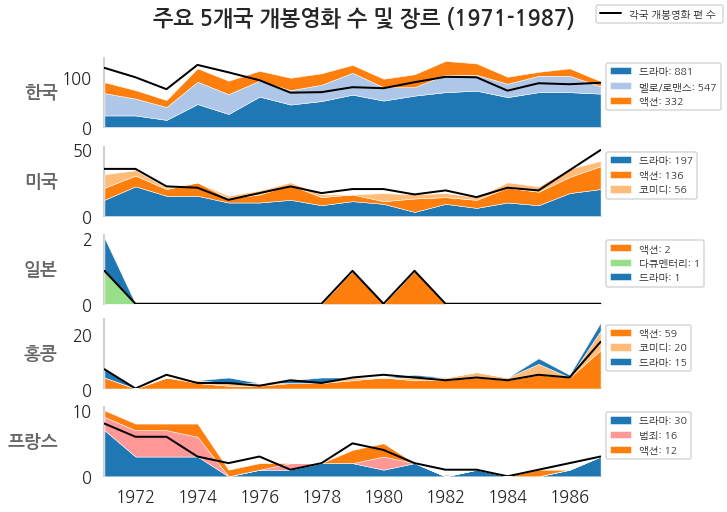

In [ ]:
plot_time_GN(1971, 1987)

In [ ]:
# 한국 영화 목록 (드라마)
df_genres.query("1971 <= openYear <= 1987").loc[df_nations["N_한국"]==1].query("G_드라마 == 1")["movieNm"].values

array(['변강쇠', '애마부인', '쥐띠부인', '앵무새 몸으로 울었다', '뻐꾸기도 밤에 우는가', '고래사냥',
       '옹기골 뽕녀', '젊은 밤 후회없다', '87 맨발의 청춘', '얄숙이들의 개성시대', '적도의 꽃',
       '내 마음의 풍차', '안개 기둥', '매일 죽는 남자', '바람불어 좋은 날', '삼포가는 길', '쇠사슬을 끊어라',
       '바다의 사자들', '최후의 증인', '별들의 고향 ', '장사의 꿈', '짝코', '바보선언', '금욕', '씨받이',
       '흐르는 강물을 어찌 막으랴', '부초', '아스팔트 위의 여자', '오계', '여기자 20년', '반금련',
       '어둠의 자식들', '과부춤', '실록 김두한', '사랑의 스잔나', '왕십리', "자유부인 '81",
       '겨울로 가는 마차', '마지막 찻잔', '길소뜸', '꼬방동네 사람들', '깊고 푸른 밤', '영웅연가',
       '먼 여행 긴 터널', '이브의 건넌방', '불행한 여자의 행복', '안녕하세요 하나님', '모정',
       '슬픔은 이제 그만', '사랑할 때와 죽을 때', '어미', '쌍둥이 꼬마신랑', '밤에도 뜨는 태양',
       '잊지 못할 모정', '내시의 아내', '장대를 잡은 여자', '탄야', '화조', '삐에로와 국화', '몸부림',
       '어느 여대생의 고백', '색깔있는 여자', '마음은 외로운 사냥꾼', '하와의 행방', '3일낮 3일밤', '이방인',
       '사람의 아들', '분례기', '만다라', '티켓', '나비 품에서 울었다', '안개마을', '우상의 눈물', '고백',
       '무녀도', '뽕', '낙동강은 흐르는가', '맨발의 눈길', '아내들의 행진', '왜 그랬던가', '증언',
       '둘째 어머니', '원한의 거리에 눈이 내린다', '13세 소년', '한강', '여수 407호', '속 여수 407호',
       '파계', '살인나비

In [ ]:
# 미국 영화 목록 (액션)
df_genres.query("1971 <= openYear <= 1987").loc[df_nations["N_미국"]==1].query("G_액션 == 1")["movieNm"].values

array(['람보 ', '에이리언 2 ', '스트리트 오브 화이어', '스타워즈', '벤허', '탑건', '데미트리아스',
       '군용열차', '사망유희', '스팔타카스', '타겟트', '페세이지', '최후의 총잡이', '프렌치 커넥션', '록키',
       '로보캅', '매드맥스', '아우트 로', '캐논볼', '원스 어폰 어 타임 인 아메리카', '더티 해리',
       '돌아오지 않는 강', '스카페이스 ', '터미네이터 ', '007 유어 아이스 온리', '007 네버세이 네버어게인',
       '람보 2', '비도권운산', '젊은이의 양지', '타워링', '카산드라 크로스', '대장 부리바', '겟어웨이',
       '원 웨이 티켓', '고릴라 ', '킹 솔로몬 ', '캐논볼 2 ', '실버스트릭', '런어웨이 ', '나바론 요새',
       '노머시', '신디케이트', '추방객', '유황도의 모래', '브레이크 아웃', '바람과 라이온', '매트 헌터 ',
       '도라,도라,도라', '이어 오브 드래곤 ', '7인의 독수리', '신밧드 대모험 호랑이 눈알', '미드웨이',
       '굿바이 브루스 리', '클레오파트라 카지노정복', '지옥의 사자들', '슈퍼맨', '더티 해리3-집행자', '스웜',
       '킹콩', '옥타곤', '스티브 맥퀸의 헌터', '쟈글라', '500만 달러의 모험', '쇼군', '솔저',
       '알카포네', '써튼 퓨리', '메카닉', '전쟁이여 잘 있거라', '샤머스', '샤프트', '크레므린 레터',
       '레드 선', '쟝글왕 타잔', '매드매드 대소동', '마제스틱', '솔저 블루', '4인의 무뢰한', '엘 콘도',
       '전격후린트 특공작전', '봐이킹', '델타포스 ', '총알을 물어라', '해저세계일주', '삼총사', '초인 사베지',
       '에어포오드 75', '스콜피오', '40인의 여도적', '이것이 법이다', '워킹톨',
      

In [ ]:
# 미국 영화 목록 (코미디)
df_genres.query("1971 <= openYear <= 1987").loc[df_nations["N_미국"]==1].query("G_코미디 == 1")["movieNm"].values

array(['빽 투 더 퓨쳐', '졸업', '메리 포핀스', '당신에게 오늘 밤을', '딸라', '싼타 빅토리아의 비밀',
       '고스트바스터즈', '캐논볼', '블루스 브라더스', '애정의 조건 ', '7인의 신부', '가브린', '구니스 ',
       '그렘린 ', '캐논볼 2 ', '실버스트릭', '스팅', '맛슈', '핑크 팬더', '위험한 여로', '럭키 레이디',
       '정오에서 3시까지', '키스미', '1941', '브레이킹 어웨이', '파울플레이', '메인 이벤트', '썬번',
       '500만 달러의 모험', '프라이비트 레슨:개인교수', '캣트로', '털보 대소동', '백작부인',
       '매드매드 대소동', '전격후린트 특공작전', '애로', '대탈옥', '솔티', '애인관계', '후리비의 대난전',
       '연애대소동', '나인 투 화이브', '로맨싱 스톤 ', '마이튜터 ', '비버리힐스 캅', '빅 트러블 ',
       '쓰리아미고 ', '인디아나 존스 - 마궁의 사원, 저주받은 사원 ', '쿼터매인 ', '텐', '투씨',
       '폴리스 아카데미 ', '폴리스아카데미 3-재훈련', '프라이빗 스쿨', '프리찌스 오너 ', '48시간 '],
      dtype=object)

In [ ]:
# 일본 영화 목록 (전체)
df_genres.query("1971 <= openYear <= 1987").loc[df_nations["N_일본"]==1]

,movieCd,movieNm,openYear,G_SF,G_가족,G_공연,G_공포,G_기타,G_다큐멘터리,G_드라마,G_멜로/로맨스,G_뮤지컬,G_미스터리,G_범죄,G_사극,G_서부극,G_성인물,G_스릴러,G_애니메이션,G_액션,G_어드벤처,G_전쟁,G_코미디,G_판타지,복합장르
18068,20108135,만국박람회,1971,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
19518,19790102,무적 가라데,1979,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
24185,19810054,격투왕,1981,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### **3.7.3. 1988-1998**

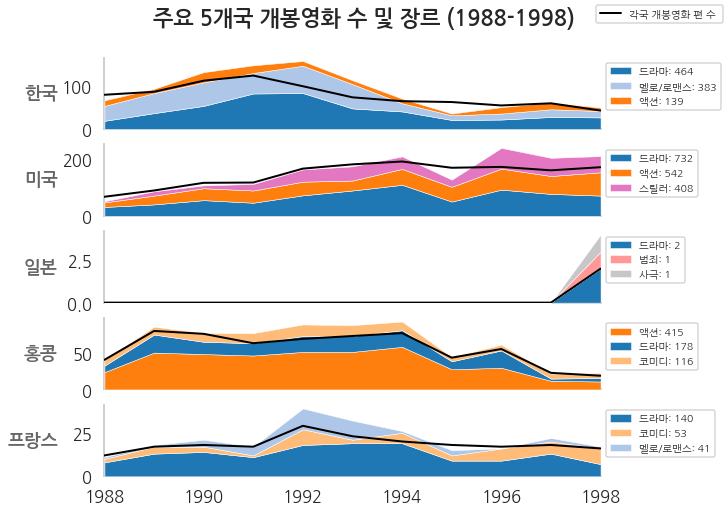

In [ ]:
plot_time_GN(1988, 1998)

In [ ]:
# 미국 영화 목록 (드라마)
df_genres.query("1988 <= openYear <= 1998").loc[df_nations["N_미국"]==1].query("G_드라마 == 1")["movieNm"].values

array(['흐르는 강물처럼', '내 남자친구의 결혼식', '이보다 더 좋을 순 없다 ', '파리의 여인', '죽은 시인의 사회',
       '늑대와 춤을', '시티 라이트', '써커스', '살인광시대', '라임라이트', '쇼걸', '지옥의 묵시록',
       '불멸의 연인 ', '마돈나 진실 혹은 대담', '재키 브라운 ', '저수지의 개들 ', '아름다운 비행 ',
       '프리 윌리 ', '알라딘', '의적 로빈후드', '쉰들러 리스트', '클리프 행어', '비엔나 호텔의 야간배달부',
       '머나먼 여정', '트루먼 쇼', '보디가드', '드라이빙 미스데이지', '사랑의 기적', '구름 속의 산책 ',
       '비포 선라이즈', '더티댄싱', '에비타 ', '환생', '칼리토 ', '실베스타스텔론의 탈옥',
       '라스트맨 스탠딩 ', '에너미 오브 스테이트', '블레이드 러너: 파이널 컷', '데이라잇', '태양의 제국',
       '벅시', '타이타닉', '콘돌', '굿 윌 헌팅', '사랑과 영혼', '포레스트 검프', '사랑의 행로', '히트',
       '미녀와 야수', '라이온 킹', '닉슨', '사랑의 용기', '미스틱 피자', '빅 나이트', 'K2',
       '트윈 픽스 ', '로스트 하이웨이 ', '데드 맨', '델마와 루이스 ', '천국보다 낯선',
       '시애틀의 잠 못이루는 밤', '제리 맥과이어', '해리가 샐리를 만났을 때', '블루 벨벳', '잉글리쉬 페이션트',
       '여인의 향기', '써머스비', '후라이드 그린 토마토', '로렌조 오일', '어느 멋진날', '순수의 시대 ',
       '커리지 언더 파이어 ', '센스 앤 센서빌리티 ', '위험한 정사', '케이프 피어', '코쿤', '쇼생크 탈출',
       '길버트 그레이프', '로리타', '흑우: 블랙레인', '로미오와 줄리엣', '가위손', '알비노 앨리게이터',
       '헤븐스 프리즈너', 

In [ ]:
# 미국 영화 목록 (스릴러)
df_genres.query("1988 <= openYear <= 1998").loc[df_nations["N_미국"]==1].query("G_스릴러 == 1")["movieNm"].values

array(['나홀로 집에', '나는 네가 지난 여름에 한 일을 알고 있다 ', '재키 브라운 ', '저수지의 개들 ',
       '터미네이터2 3D', '양들의 침묵', '황혼에서 새벽까지', '클리프 행어', '폭풍속으로', '환생',
       '실베스타스텔론의 탈옥', '에너미 오브 스테이트', '숀 코네리의 함정 ', '가면의 정사', '데이라잇',
       '불같은 약속', '콘돌', '세븐', '유주얼 서스펙트', '히트', '사랑의 용기', '로스트 하이웨이 ',
       '블루 벨벳', '위험한 정사', '케이프 피어', '다크시티', '알비노 앨리게이터', '데블스 오운',
       '헤븐스 프리즈너', '언터처블', '누가 로저래빗을 모함했나', '퍼블릭 에너미 NO 1', '하베스트',
       '배트맨 앤 로빈', '007 제18편 : 네버 다이', '마젠타의 숲', '에어 포스 원', '위험한 커플',
       '애증의 심판', '딥 다운', '거울속의 정사', '퍼팩트 타겟', '하드 타겟', '패신져 57',
       '네 이웃의 아내를 탐하지마라', '불사신', '킬링 타켓', '페이 백', '섀도우 프로그램', '메이데이',
       '에이리언3', '더 게임', '스카 시티', '리쎌웨폰 4 ', '블러드 라인', '글라스 케이지', '스피시즈 2',
       '프라퍼시 2', '파리의 늑대인간 ', '글렌게리 글렌로스', '고스트 앤 다크니스 ', '광란의 정사',
       '계부 3', '가디안', '글리머 맨 ', '겟 쇼티 ', '광란의 시간', '개목걸이', '화이어 다운 ',
       '공포의 수학열차', '크러쉬', '퀘스트 ', '아더는 영혼을 살해했다', '위험한 증거 ', '머홀랜드 폴스 ',
       '맥시멈 리스크 ', '마담 엠마', '일루션 ', '인베이더', '펜타트론 ', '다크 앤젤', '다락방에 핀 꽃',
       '나이트 러닝맨 ', '은밀한 게

In [ ]:
# 미국 영화 목록 (애니메이션)
df_genres.query("1988 <= openYear <= 1998").loc[df_nations["N_미국"]==1].query("G_애니메이션 == 1")["movieNm"].values

array(['알라딘', '벅스 라이프', '미녀와 야수', '뮬란', '라이온 킹', '인어공주 ', '토이 스토리 ',
       '난 이상한 사람과 결혼했다', '백조 공주 ', '톰과 제리', '공룡시대', '개미',
       '팀 버튼의 크리스마스 악몽', '포카혼타스 ', '정글북', '찰리의 하늘나라 대소동', '푸른 골짜기',
       '이집트 왕자', '매직 스워드 ', '스페이스 잼', '월트디즈니의 노틀담의 꼽추 ', '머팻 크리스마스 캐롤',
       '양배추인형의 클럽하우스 ', '아나스타샤', '월트디즈니의 헤라클레스 '], dtype=object)

In [ ]:
# 홍콩 영화 목록 (액션)
df_genres.query("1988 <= openYear <= 1998").loc[df_nations["N_홍콩"]==1].query("G_액션 == 1")["movieNm"].values

array(['의본무언', '살수특급', '화평본위 ', '신정무문', '동성서취', '땡큐마담', '천장지구 2', '종횡사해',
       '첩혈쌍웅', '천장지구', '영웅본색 3', '주윤발의 미스터 갱', '백발마녀전 2', '패가자', '시티 헌터',
       '비룡맹장', '아비와 아기 ', '대도무문', '영웅본색 2', '대호출격', '소오강호', '폴리스 스토리',
       '직격증인', '양리칭의 예스마담', '황비홍의서역웅사', '황비홍3-사왕쟁패', '황비홍 2', '엽표행동',
       '무장원 소걸아', '도범2', '용형호제 2', '감옥풍운', '중환영웅', '황비홍', '예스 마담2-황가전사',
       '열화전차', '첩혈가두', '폴리스 스토리3', '폴리스 스토리 2 - 구룡의 눈', '소림사강호영패 ',
       '조수괴초', '첩혈남아 ', '지존본색', '백발 마녀전', '화소도', '가두패왕', '광동오호',
       '철마류-가두살수', '마담 캅스', '성룡의 폴리스 스토리 4', '독망', '적나고양 2', '용호상조',
       '지존애림2', '동방불패 2', '땡큐마담 2', '독고구검', '흑금', '예스 마담3-중화전사', '특경도룡',
       '공작왕', '칠복성', '모험왕 ', '성룡의 미라클', '용행천하', '동방불패', '영웅 ', '동방삼협',
       '흑협', '기밀중안 ', '글로리아 입의 캣츠', '경천여장', '구마도장', '고혹녀 ', '경망쌍웅', '가자왕',
       '귀호', '귀타여걸', '귀도귀', '귀경출사', '강시지존', '동사서독 ', '홍콩 여복성', '패왕화',
       '경천12시', '공작왕 2 아수라', '광천용호투', '구복성', '군룡희봉', '수호전지 영웅본색', '초류향',
       '진가락', '지존여장', '명월조천신사', '두호통집범 ', '도신불패 ', '도성대형', '용소자',
       '

In [ ]:
# 홍콩 영화 목록 (범죄)
df_genres.query("1988 <= openYear <= 1998").loc[df_nations["N_홍콩"]==1].query("G_범죄 == 1")["movieNm"].values

array(['메이드 인 홍콩 ', '종횡사해', '첩혈쌍웅', '영웅본색 2', '직격증인', '엽표행동', '용형호제 2',
       '첩혈가두', '폴리스 스토리 2 - 구룡의 눈', '첩혈남아 ', '화소도', '마담 캅스', '독망', '의담비봉',
       '노호광', '성룡의 미라클', '흑협', '경망쌍웅', '귀경출사', '흑사회', '지존여장', '도성대형',
       '살출군영', '성항기병 3 : 홍콩탈출', '자웅쌍혈', '중안조', '이연걸의 탈출', '폴리스 갱', '무림쌍걸',
       '이락부기안 ', '증인', '폭풍의 눈 ', '폭열도시', '정홍기하', '블랙캣', '성향기병 IV 사자후 ',
       '굉천 황가장', '용등사해', '쾌락적 소야계', '첩혈속집', '대적성', '맨하탄 잠복근무 ', '신영웅본색 ',
       '의혈강호 ', '와일드 커플 ', '킬러의 3.5분 ', '지존마담', '라스트 예스마담 ', '현대 고혹자 ',
       '신첩혈쌍웅 ', '메탈 캅스 ', '혈염홍진', '묘가십이소', '동방노호', '천라지망', '도성 2',
       '사해교룡', '성시판관', '파호', '살수특경', '와일드 엔젤', '노화가두', '뇌정소혈', '독호',
       '의불용정', '뇌락정구', '용혈미정', '용가호저', '신탐격전', '기병', '여도신', '경시종횡',
       '정고전가', '성전강호', '성시연가', '비호 ', '나이스가이 ', '색겁정겁', '구룡본색',
       '로얄포리스 마담', '마담갱', '빅보스', '여걸풍운', '엽응계획', '영웅사저', '용지쟁패', '의본대형',
       '포리스우먼', '프린세스 마담', '흑도영웅', '흑전사'], dtype=object)

In [ ]:
# 한국 영화 목록 (코미디)
df_genres.query("1988 <= openYear <= 1998").loc[df_nations["N_한국"]==1].query("G_코미디 == 1")["movieNm"].values

array(['조용한 가족', '마누라 죽이기', '3인조', '미지왕', '개그맨', '기막힌 사내들', '결혼이야기',
       '넘버 3', '개같은 날의 오후', '아래층 여자와 위층 남자', '박봉곤 가출사건', '닥터 봉', '할렐루야',
       '나의 사랑, 나의 신부', '패자부활전', '투캅스', '세상 밖으로', '누가 나를 미치게 하는가',
       '땡칠이와 쌍라이트', '진짜 사나이', '생과부 위자료 청구소송', '남자는 괴로워', '투캅스 3', '투캅스 2',
       '아기공룡 둘리-얼음별 대모험', '계약 커플', '개그특공대 로봇트윈스', '체인지', '비는 사랑을 타고',
       '커피 카피 코피', '억수탕(3pm Paradise)', '가진 것 없소이다', '가루지기', '결혼이야기 2',
       '소쩍궁 탐정', '미끼', '장닭 고교얄개', '요절복통 신 양반뎐', '오색의 전방', '똑바로 살아라',
       '돈을 갖고 튀어라', '헤어드레서', '오디션', '영구와 공룡 쮸쮸', '가보면 알거야', '맨',
       '꼬리치는 남자', '도둑과 시인', '머저리와 등신들', '총잡이', '천재선언', '내일은 참피온',
       '아빠는 보디가드', '가족시네마', '키스할까요', '엑스트라', '찜', '코르셋', '토요일 오후2시',
       '죽이는 이야기', '소녀 18세', '사랑하고 싶은 여자 결혼하고 싶은 여자', '쿵후보이 친미',
       '우뢰매 7 : 돌아온 우뢰매', '로맨스 황제', '미스터 맘마', '영구와 흡혈귀 드라큐라', '정신나간 유령',
       '머저리와 도둑놈', '영구와 황금박쥐', '맹구와 북두신검', '삼중성', '토끼를 태운 잠수함',
       '영구와 땡칠이 4탄-홍콩할매귀신', '병팔이의 일기', '따봉수사대-밥풀떼기 형사와 전봇대 형사', '인연',
       '일팔일팔(1818)', '스카이 닥터', '현상수

In [ ]:
# 한국 영화 목록 (스릴러)
df_genres.query("1988 <= openYear <= 1998").loc[df_nations["N_한국"]==1].query("G_스릴러 == 1")["movieNm"].values

array(['올가미', '여고괴담', '장미의 나날', '태양 속의 남자', '가위여자', '천년환생', '피아노맨', '손톱'],
      dtype=object)

In [ ]:
# 한국 영화 목록 (공포)
df_genres.query("1988 <= openYear <= 1998").loc[df_nations["N_한국"]==1].query("G_공포 == 1")["movieNm"].values

array(['301·302', '퇴마록', '올가미', '여고괴담', '구미호', '천년환생', '신의 이방인',
       '영구와 흡혈귀 드라큐라', '천녀원앙'], dtype=object)

In [ ]:
# 한국 영화 목록 (여고괴담 시리즈)
df_genres.loc[df_genres["movieNm"].str.contains("여고")]

,movieCd,movieNm,openYear,G_SF,G_가족,G_공연,G_공포,G_기타,G_다큐멘터리,G_드라마,G_멜로/로맨스,G_뮤지컬,G_미스터리,G_범죄,G_사극,G_서부극,G_성인물,G_스릴러,G_애니메이션,G_액션,G_어드벤처,G_전쟁,G_코미디,G_판타지,복합장르
6600,19990056,여고괴담 두번째 이야기,1999,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10820,20030100,여고괴담 세번째 이야기: 여우계단,2003,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11990,20141143,이지메-여고생의 혼잣말,2016,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
12244,19980035,여고괴담,1998,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
12586,20090327,여고괴담 5,2009,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
13392,20050252,신주쿠 여고생 납치사건(완전한 사육),2005,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13616,20088594,소녀괴담 : 17살 여고생의 악몽,2015,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
14301,20000047,대학로에서 매춘하다가 토막살해당한 여고생 아직 대학로에 있다,2000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
17723,20050142,여고괴담 4 : 목소리,2005,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18918,19720052,여고시절,1972,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 한국 영화 목록 (드라마)
df_genres.query("1988 <= openYear <= 1998").loc[df_nations["N_한국"]==1].query("G_드라마 == 1")["movieNm"].values

array(['서울에비타', '빠담풍', '해가 서쪽에서 뜬다면', '접속', '조용한 가족', '마스카라', '나쁜 영화',
       '부활의 노래', '있잖아요 비밀이에요', '돼지가 우물에 빠진 날', '달마가 동쪽으로 간 까닭은?', '본 투 킬',
       '칠수와 만수', '축제', '초록물고기', '8월의 크리스마스', '파업전야', '마누라 죽이기', '영심이',
       '장군의 아들 2', '아름다운 청년 전태일', '우리들의 일그러진 영웅', '산딸기 5', '개그맨',
       '가슴에 돋는 칼로 슬픔을 자르고', '기막힌 사내들', '게임의 법칙', '사랑하기 좋은 날', '쫄병수첩',
       '여군외출', '아들나라', '세상은 살만큼 아름답다', '알바트로스', '밀월', '서편제', '백치애인',
       '걸어서 하늘까지', '불행한 아이의 행복', '복카치오 `93', '이혼녀', '무궁화꽃이 피었습니다', '말미잘',
       '명자 아끼꼬 쏘냐', '마유미', '결혼이야기', '남부군', '칠삭동이의 설중매 ', '처녀들의 저녁식사',
       '세 친구', '키드캅', '정사', '달은...해가 꾸는 꿈', '두여자 이야기', '은마는 오지 않는다',
       '개같은 날의 오후', '학생부군신위', '미술관 옆 동물원', '편지', '별이 빛나는 밤에',
       '아래층 여자와 위층 남자', '장군의 아들 3', '장군의 아들', '올가미', '달콤한 신부들', '여자의 일생',
       '눈꽃', '행복은 성적순이 아니잖아요', '바람부는 날이면 압구정동에 가야 한다', '그대안의 블루',
       '아제아제 바라아제', '우리는 지금 제네바로 간다', '꽃잎', '너에게 나를 보낸다', '경마장 가는 길',
       '무소의 뿔처럼 혼자서 가라', '그들도 우리처럼', '강원도의 힘', '할렐루야', '나의 사랑, 나의 신부',
       '태백산맥', '투캅스', 

### **3.7.4. 1999-2010**

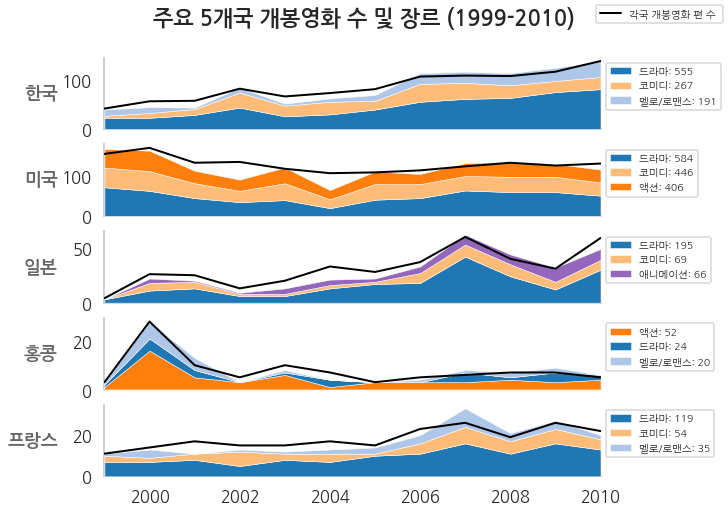

In [ ]:
plot_time_GN(1999, 2010)

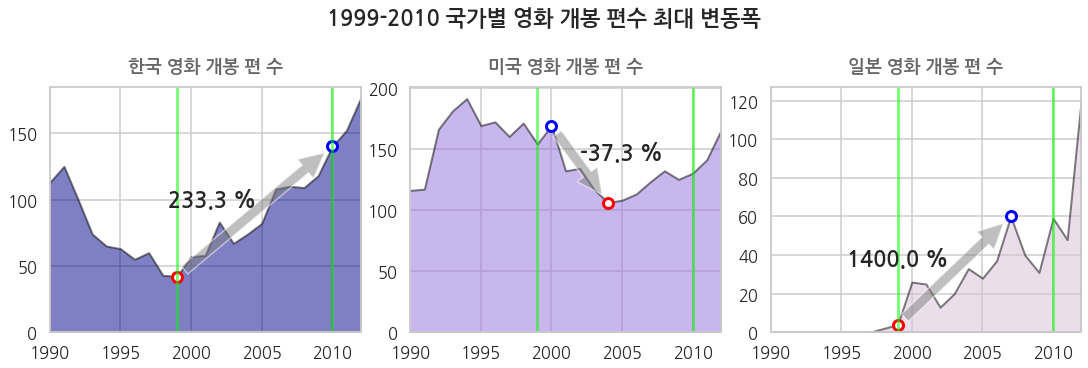

In [ ]:
# 한국, 미국, 일본 개봉 편 수 비교
from matplotlib.patches import FancyArrowPatch

fig, axs = plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True, sharex=True)

for (ax, n, c) in zip(axs, ["한국", "미국", "일본"], [c_kr, c_us, c_jp]):
    df = df_nationsY.query("1988 <= openYear <= 2012")
    ax.stackplot(df["openYear"], df[f"N_{n}"], colors=[c], ec="k", lw=2, alpha=0.5)
    min_x = df.query("1999 <= openYear <= 2010")["openYear"].iloc[df.query("1999 <= openYear <= 2010")[f"N_{n}"].argmin()]
    min_y = df.query("1999 <= openYear <= 2010")[f"N_{n}"].min()
    max_x = df.query("1999 <= openYear <= 2010")["openYear"].iloc[df.query("1999 <= openYear <= 2010")[f"N_{n}"].argmax()]
    max_y = df.query("1999 <= openYear <= 2010")[f"N_{n}"].max()
    ax.scatter(min_x, min_y, s=100, ec="r", lw=3, fc="w")
    ax.scatter(max_x, max_y, s=100, ec="b", lw=3, fc="w")
    
    arrow_start_x, arrow_end_x = (min_x, max_x) if min_x < max_x else (max_x, min_x)
    arrow_start_y, arrow_end_y = (min_y, max_y) if min_x < max_x else (max_y, min_y)
    arrow = FancyArrowPatch((arrow_start_x, arrow_start_y), (arrow_end_x, arrow_end_y),
                            shrinkA=10, shrinkB=10, mutation_scale=50, fc="gray", alpha=0.5)
    ax.add_artist(arrow)
    shift_x = 0
    if n == "한국":
        shift_x = -3
    elif n == "미국":
        shift_x = 3
    elif n == "일본":
        shift_x = -4
    ax.text((min_x + max_x)/2 +shift_x, (min_y + max_y)/2, f"{(arrow_end_y - arrow_start_y)/arrow_start_y*100:.1f} %", 
            fontsize="large", fontweight="bold", ha="center", va="bottom")
    
    ax.axvline(1999, lw=3, c="#00FF00", alpha=0.5)
    ax.axvline(2010, lw=3, c="#00FF00", alpha=0.5)
    ax.set_xlim(1990, 2012)
    ax.set_title(f"{n} 영화 개봉 편 수", fontdict=font_title, pad=16)
    
fig.suptitle("1999-2010 국가별 영화 개봉 편수 최대 변동폭\n", fontweight="bold")
fig.savefig("./images/num_delta.png", dpi=200)

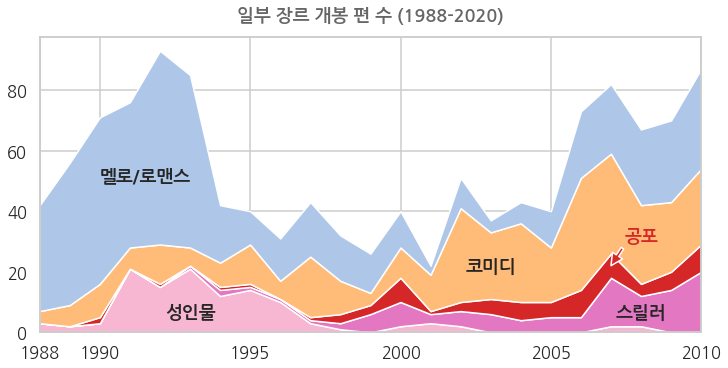

In [ ]:
# 한국 성인물 vs 액션

fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)

ax.stackplot(df_genresY_kr.query("1988 <= openYear <= 2010")["openYear"], 
             [df_genresY_kr.query("1988 <= openYear <= 2010")["G_성인물"], 
              df_genresY_kr.query("1988 <= openYear <= 2010")["G_스릴러"], 
              df_genresY_kr.query("1988 <= openYear <= 2010")["G_공포"], 
              df_genresY_kr.query("1988 <= openYear <= 2010")["G_코미디"], 
              df_genresY_kr.query("1988 <= openYear <= 2010")["G_멜로/로맨스"]],
             colors=[c_ero, c_thriller, c_horror, c_comedy, c_romance], labels=["성인물", "스릴러", "공포", "코미디", "멜로/로맨스"])
ax.set_xlim(1988, 2010)
ax.set_title("일부 장르 개봉 편 수 (1988-2020)", fontdict=font_title, pad=16)

ax.text(1993, 5, "성인물", fontweight="bold", ha="center")
ax.text(2008, 5, "스릴러", fontweight="bold", ha="center")
ax.annotate("공포", (2007, 22), (2008, 30),  c=c_horror, fontweight="bold", ha="center", 
            arrowprops={"width":3, "fc":c_horror})
ax.text(2003, 20, "코미디", fontweight="bold", ha="center")
ax.text(1991.5, 50, "멜로/로맨스", fontweight="bold", ha="center")

xticks = [1988, 1990, 1995, 2000, 2005, 2010]
ax.set_xticks(xticks)
fig.savefig("./images/genre_change_1988.png", dpi=200)

In [ ]:
df_genresY_kr.query("1988 <= openYear <= 1998")["G_성인물"]/df_nationsY.query("1988 <= openYear <= 1998")["N_한국"]

17    0.037500
18    0.022989
19    0.026549
20    0.168000
21    0.150000
22    0.283784
23    0.184615
24    0.222222
25    0.181818
26    0.050000
27    0.023256
dtype: float64

In [ ]:
print(df_genres_kr.query("1988 <= openYear <= 1998").query("G_성인물==1")["movieNm"].values)

['산딸기 5' '산딸기 6' '산딸기 4' '복카치오 `93' '그 여자의 숨소리' '고금소총 2' '고금소총 3'
 '거부하는 몸짓으로 저 하늘을' '금병풍월' '꿈의 정사' '꾼사냥' '갈마' '끼있는 여자는 밤이슬을 좋아한다' '배꼽위에 여자'
 '데카당스 37.2' '겨울애마, 봄' '서울 엠마누엘' '러브호텔 비상구' '리허설' '안개 속에서 2분 더' '서울 미란다'
 '95 캉캉 69' '에로틱 걸' '애마와 백수건달' '매춘 6' '동춘별곡' 'B타임의 정사 4' '빨간앵두 8'
 '짧은 시간 긴 시간' '드라큐라 애마' '립스틱 그리고 남자의 사랑' '하몽하몽 서울' '자정이후' '비,여자 그리고 에로티시즘'
 '애마와 변강쇠' '미란다' '매춘 5' '애마부인 11' '숲속의 여자' '에로스 2' '96 옐로우 하우스' '하얀 노을'
 '에로엑스' '물위의 하룻밤' '콜렉터' '립스틱 짙게 바르고' '여자가 타락하는 이유' '홧김에?' '헬로우 변강쇠'
 '맥주가 애인보다 좋은 7가지 이유' '불륜의 바다' '애마부인 9' '도색부인' '뽕띠' 'B타임의 정사' '봉성부인'
 '무인도의 남과 여' '뽕 3' '성애의 침묵' '캉캉 69' '소녀경' '애마부인 7' '안개에 젖은 리오의 밤은 깊어'
 '복카치오 92' '늪속의 불안개는 잠들지 않는다' '변금련 2' '매춘 3' '여자아리랑' 'B타임의 정사 3'
 '연인들의 멜로디' '사라의 계절' '무엇에 쓰는 물건인고' '성인(Adult Movie)스' '애마부인 8' 'B타임의 정사 2'
 '탄드라부인' '애마부인 6' '뽕밭나그네' '바람불면 일어서는 숲' "복카치오' 91" '성숙한 외출'
 '엑스(X)성을 가진 여자' '팁주는 여자' '애마부인 5' '밥만 먹고 못살아' '변금련' '어느 중년부인의 위기'
 '달빛타는 여자' '미아리텍사스' '후리꾼' '무릎위의 여자' '스커트 속의 드라마' '크레이지 댄스' '사랑 그리고 죽는 연습'
 '매춘 2' '매춘 4' '변강쇠 3' '복

In [ ]:
# 한국 영화 목록 (코미디)
df_genres.query("1999 <= openYear <= 2010").loc[df_nations["N_한국"]==1].query("G_코미디 == 1")["movieNm"].values

array(['음란서생', '당신이 잠든 사이에', '미녀는 괴로워', '마이 뉴 파트너', '국가대표', '나두야 간다',
       '광식이 동생 광태', '구미호 가족', '걸스카우트', 'YMCA야구단', '몽정기2', '그때 그 사람들',
       '여교수의 은밀한 매력', '엽기적인 그녀', '지구를 지켜라', '일단뛰어', '반칙왕', '아치와 씨팍',
       '브라보 마이 라이프', '마법경찰 갈갈이와 옥동자', '나는 곤경에 처했다!', '꿈은 이루어진다', '미쓰 홍당무',
       '청담보살', '원스어폰어타임', '울학교 이티', '어린 신부', '순정만화', '귀여워', '선생 김봉두',
       '대한민국 헌법 제1조', '헬로우 마이 러브', '낮술', '뭘 또 그렇게까지', '이웃집 좀비', '화산고',
       '우린 액션배우다', '은하해방전선', '1번가의 기적', '최강로맨스', '헬로우 고스트', '아기와 나',
       '무림여대생', '펀치레이디', '구타유발자들', '주유소 습격사건 2', '방자전', '달콤한 거짓말',
       '내 눈에 콩깍지', '마이 캡틴 김대출', '굿모닝 프레지던트', '권순분여사 납치사건', '바르게 살자', '싸움',
       '슈퍼맨이었던 사나이', '차우', '누가 그녀와 잤을까?', '삼거리극장', '언니가 간다', '마파도2',
       '색즉시공 시즌2', '만남의 광장', '못말리는 결혼', '이장과 군수', '구세주', '예의없는 것들',
       'B형 남자친구', '연애술사', '좋지 아니한가', '동갑내기 과외하기 레슨 2', '투사부일체', '방과후 옥상',
       '모두들, 괜찮아요?', '귀신이 산다', 'S 다이어리', '여선생 VS 여제자', '달마야, 서울 가자',
       '돈 텔 파파', '달마야 놀자', '파송송 계란탁', '마파도', '연애의 목적', '박수칠 때 떠나라',
       '싸움의 기술',

In [ ]:
# 일본 영화 목록 (코미디)
df_genres.query("1999 <= openYear <= 2010").loc[df_nations["N_일본"]==1].query("G_코미디 == 1")["movieNm"].values

array(['뒤에서 앞에서', '혐오스런 마츠코의 일생', '안경', '요시노 이발관', '키사라기 미키짱', '훌라걸스',
       '다케시즈', '기쿠지로의 여름', '모두 하고 있습니까?', '피쉬 스토리', '신부의 수상한 여행가방',
       '이웃집 야마다군', '고양이의 보은', '폼포코 너구리 대작전', '괜찮아, 정말 괜찮아', '토일렛', '텐텐',
       '개구리중사 케로로', '남극의 쉐프', '구구는 고양이다', '개 달리다', '간장선생',
       '명랑한 갱이 지구를 움직인다', '포켓몬스터 - 뮤츠의 역습', '춤추는 대수사선 2',
       '노다메 칸타빌레 Vol.1 ', '투엘디케이', '디트로이트 메탈 시티', '3-4X10월',
       '스즈미야 하루히의 소실', '사무라이픽션 - 적영', '마미야 형제', '눈물이 주룩주룩', '포스트맨 블루스',
       '워터 보이즈', '퍼머넌트 노바라', '녹차의 맛', '우리들과 경찰아저씨의 700일 전쟁',
       '짱구는 못말려 극장판:태풍을 부르는 노래하는 엉덩이 폭탄', '원피스 - 기계태엽성의 메카거병', '해피 플라이트',
       '워터스', '전차남', '도쿄 마블 초콜릿', '지옥갑자원', '자살관광버스', '린다 린다 린다', '스윙걸즈',
       '웰컴 미스터 맥도날드', '으랏차차 스모부', '열흘 밤의 꿈', '매직 아워', '춤추는 대수사선',
       '아르헨티나 할머니', '상하이의 밤', '사무라이 픽션', '콰이어트 룸에서 만나요',
       '케로로 더 무비:케로로 VS 케로로 천공대결전', '소림소녀', '극장판 도라에몽:진구의 마계대모험 7인의 마법사',
       '달은 어디에 떠 있는가', '하나', '달려라! 타마코', '마츠가네 난사사건', '비밀의 화원', '팬시댄스',
       '행복한 가족계획', '생일선물', '붕대클럽'], dtype=object)

In [ ]:
# 한국 영화 목록 (액션)
df_genres.query("1999 <= openYear <= 2010").loc[df_nations["N_한국"]==1].query("G_액션 == 1")["movieNm"].values

array(['마이 뉴 파트너', '국가대표', '청풍명월(淸風明月)', '소년은 울지 않는다', '사생결단', '일단뛰어',
       '클레멘타인', '아치와 씨팍', '원더풀 데이즈', '한반도', '인정사정 볼 것 없다', '말죽거리 잔혹사',
       '좋은 놈, 나쁜 놈, 이상한 놈 ', '죽거나 혹은 나쁘거나', '아저씨', '원스어폰어타임', '추격자',
       '달콤한 인생', '의형제', '쉬리', '형사 Duelist', '짝패', '무적자', '용가리', '하류인생',
       '이웃집 좀비', '숙명', '화산고', '마린보이', '2009로스트메모리즈', '우린 액션배우다', '비열한 거리',
       '킬리만자로', '해운대', '미스터 소크라테스', '피도 눈물도 없이', '해결사', '공공의 적', '황해',
       '무림여대생', '주유소 습격사건 2', '평행이론', '무방비도시', '신기전', '차우', '인사동 스캔들',
       '거룩한 계보', '열혈남아', '강철중: 공공의 적 1-1', '구세주', '예의없는 것들', '수', '강력 3반',
       '바람의 파이터', '조폭마누라2-돌아온 전설', '천년호', '아 유 레디?', '흑수선', '정글쥬스',
       '7급 공무원', '리베라메', '유령', '디워', '주유소 습격사건', '거북이 달린다', '무영검', '전우치',
       '사랑', '비상', '해바라기', '영화는 영화다', '다찌마와리', '무사', '아라한 장풍대작전',
       '우아한 세계', '태풍', '태양은 없다', '대한민국 1%', '육혈포 강도단', '눈에는 눈 이에는 이',
       '야수', '잠복근무', '조폭마누라3', '천군', '바람', '홍길동의 후예', '아나키스트', '비천무',
       '구르믈 버서난 달처럼', '보트', '튜브', '뚝방전설', '중천', '웨스트 32번가', '컷 런스 딥',
       

In [ ]:
# 한국 영화 목록 (스릴러)
df_genres.query("1999 <= openYear <= 2010").loc[df_nations["N_한국"]==1].query("G_스릴러 == 1")["movieNm"].values

array(['기담', '범죄의 재구성', '송어', '해피엔드', '섬', '제불찰씨 이야기', '살인의 추억',
       '사람을 찾습니다', '케이티', '친절한 금자씨', '귀 鬼', '악마를 보았다', '추격자', '복수는 나의 것',
       '궁녀', '마린보이', '작전', '이태원 살인사건', '하녀', '고死 두 번째 이야기: 교생실습', '해결사',
       '무법자', '황해', '나의 친구, 그의 아내', '더 게임', '세븐 데이즈', '조용한 세상', '평행이론',
       '이끼', '백야행', '시크릿', '리턴', '우리 동네', '그놈 목소리', '극락도 살인사건', '검은 집',
       '달콤, 살벌한 연인', '남극일기', '두뇌유희프로젝트, 퍼즐', '라라 선샤인', '김복남 살인사건의 전말',
       '얼굴 없는 미녀', '혈의 누', 'GP 506', '심야의 F.M.', '그림자 살인', '올드보이', '텔미썸딩',
       '홀리데이', '베스트셀러', '오로라 공주', '고死 : 피의 중간고사', '진실게임', '용서는 없다', '10억',
       '브레인웨이브', '반가운 살인자', '여고괴담 5', '눈에는 눈 이에는 이', '죽이고 싶은', '파괴된 사나이',
       '목두기 비디오', '주홍글씨', '핸드폰', '가면', '링', '여의도', '블러디쉐이크', '뷰티풀 선데이',
       '엠', '이중간첩', '페티쉬', '배니싱 트윈', 'H(에이치)', '해부학 교실', '해안선', '실종',
       '아티스트', '죽어도 해피엔딩', '쓰리', '써클', '엄지아빠', '플라스틱 트리', '4인용 식탁', '외톨이',
       '파라다이스빌라', '세이예스', '이것이 법이다', '4교시 추리영역', '이브의 유혹 - 그녀만의 테크닉',
       '이브의 유혹 - 키스', '이브의 유혹 - 엔젤', '해변으로가다', '삼양동 정육점', '건축무

In [ ]:
# 한국 영화 목록 (멜로/로맨스)
df_genres.query("1999 <= openYear <= 2010").loc[df_nations["N_한국"]==1].loc[df_genres["G_멜로/로맨스"]==1]["movieNm"].values

array(['미녀는 괴로워', '연리지', '동감', '버스, 정류장', '해피엔드', '사과', '나는 곤경에 처했다!',
       '말죽거리 잔혹사', '너는 내 운명', '멋진 하루', '김종욱 찾기', '파주', '청담보살', '두 번째 사랑',
       '토끼와 리저드', '나는 행복합니다', '잘 알지도 못하면서', '해변의 여인', '신부수업', '쉬리',
       '순정만화', '모던보이', '형사 Duelist', '호우시절', '친구사이?', '헬로우 마이 러브', '하하하',
       '뭘 또 그렇게까지', '미인도', '두 여자', '회오리 바람', '은하해방전선', '생활의 발견',
       '내 머리 속의 지우개', '최강로맨스', '불후의 명작', '하녀', '나도 아내가 있었으면 좋겠다',
       '내 마음의 풍금', '...ing', '어깨 너머의 연인', '무림여대생', '페어러브', '방자전',
       '달콤한 거짓말', '내 눈에 콩깍지', '백야행', '지금 사랑하는 사람과 살고 있습니까?', '싸움',
       '아내가 결혼했다', '불꽃처럼 나비처럼', '사랑할 때 이야기하는 것들', '구세주', '연애술사',
       '동갑내기 과외하기 레슨 2', '사랑을 놓치다', '로망스', '달콤, 살벌한 연인', '도마뱀',
       '연애, 그 참을 수 없는 가벼움', '연애의 목적', '내 생애 가장 아름다운 일주일', '러브토크', '천년호',
       '시월애', '바람피기 좋은 날', '사랑니', '초감각 커플', '싸이보그지만 괜찮아', '백만장자의 첫사랑',
       '내 사랑 내 곁에', '맛있는 인생', '사랑 따윈 필요 없어', '용의주도 미스신', '순애보',
       '조금만 더 가까이', '외출', '내 여자친구를 소개합니다', '카라', '황진이', '첫눈', '반두비',
       '가을로', '키친', '사랑', '비상', '결혼은, 미친짓이다

In [ ]:
# 프랑스 영화 목록 (스릴러)
df_genres.query("1999 <= openYear <= 2010").loc[df_nations["N_프랑스"]==1].query("G_스릴러 == 1")["movieNm"].values

array(['유(U) - 571', '히든', '테이큰', '더 독', '서브웨이', '돌이킬 수 없는', '페이지 터너',
       '유령작가', '13 자메티', '안소니 짐머', '크림슨 리버', '웨이트 오브 워터',
       '레지던트 이블 3 - 인류의 멸망', '라르고 윈치', '마터스: 천국을 보는 눈', '프롬 파리 위드 러브',
       '클로이', '페이싱', '카운테스', '나는 비와 함께 간다', '하이 레인', '미로', '바디 스내치',
       '엑시트', '뎀', '식스 팩', '멜로디의 미소', '더 시크릿', '보딩 게이트'], dtype=object)

In [ ]:
# 한국 영화 목록 (미국)
df_genres.query("1999 <= openYear <= 2010").loc[df_nations["N_미국"]==1].query("G_스릴러 == 1")["movieNm"].values

array(['시티 오브 갓', '메멘토', '리플리', '스크림', '목요일', '28일 후', '콰이어트 맨',
       '퍼펙트 스트레인저', '노인을 위한 나라는 없다', '언스토퍼블', '데어 윌 비 블러드',
       '람보 4 : 라스트 블러드', 'K-19', '그랜 토리노', '당신이 사랑하는 동안에', '콘스탄틴',
       '파이트 클럽 ', '워', '본 얼티메이텀', '악마가 너의 죽음을 알기전에', '이스턴 프라미스', '더 클럽',
       '미스터 브룩스', '원초적 본능 2', '조디악', '로드 오브 워', '우주전쟁', '파라노말 액티비티',
       '아이즈  와이드 셧', '6번째 날', '인사이더', '패닉 룸', '데블스 워닝', '다크 프린스',
       '언더 프레셔', '차일드 콜렉터', '우먼 오브 더 나잇', '언세드', '너스 베티', '비트 시티 ',
       '터뷸런스 2', '심플 플랜', '킹 코브라', '북 오브 섀도우', '레드 플래닛', '식스티 세컨즈',
       '레인디어 게임', '싸이퍼', '스테이트 오브 플레이', '월 스트리트: 머니 네버 슬립스', 'pm 11:14',
       '고스트 라이더', '그라운드 콘트롤', '미드나잇 미트 트레인', 'H2: 어느 살인마의 가족이야기 ',
       '글래스하우스', '그남자는 거기 없었다', '트리플 X2 : 넥스트 레벨', '그루지 3', '굿바이 러버',
       '쏘우 V', '더 야드', '위 오운 더 나잇', '브레이브 원', '트로미오와 줄리엣', '터치미', '넥스트',
       '씬 시티', '스톰캣처', '스위니 토드 : 어느 잔혹한 이발사 이야기', '보일러룸', '임포스터',
       '유주얼 서스펙트 2', '데스티네이션', '카오스팩터', '펠햄 123', '콰이어트 아메리칸', '글로리아',
       '뮌헨', '텍사스 전기톱 연쇄살인사건 : 0', '대통령을 죽여라

### **3.7.5. 2011-2020**

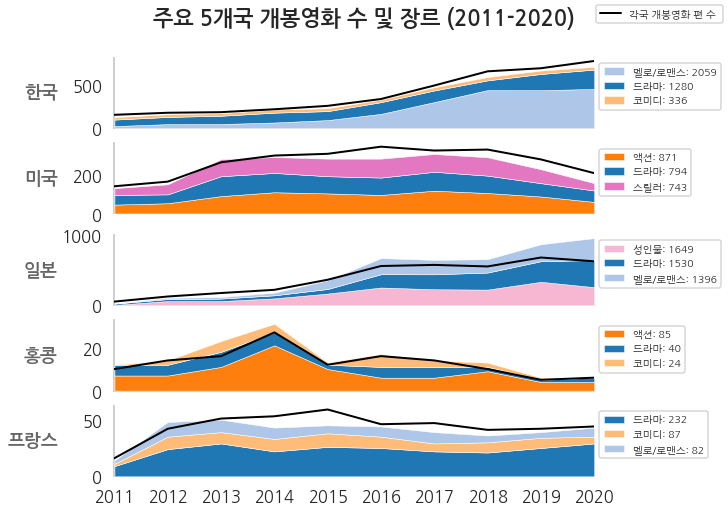

In [ ]:
plot_time_GN(2011, 2020)

In [ ]:
# 일본 영화 목록 (성인물)
print(df_genres.query("2011 <= openYear <= 2020").loc[df_nations["N_일본"]==1].query("G_성인물 == 1")["movieNm"].values[:100])

['육덕녀의 황홀한 서비스' '대학선배에게 뺏긴 약혼녀' '나만의 판타지 섹스2' '나만의 판타지 섹스'
 '야간학교 : 음란한 누나들의 아찔한 수업' '흑심을 보인 시아버지' '첫키스부터 XX까지 엄마친구' '여자마사지사는 정말 주는가'
 '술취한 직장후배와 원나잇 가능' '선넘은 F컵 물리치료사' '육덕 여직원과 러브호텔에서...' '신인 AV 여배우의 첫 촬영'
 '피부좋은 육덕 새엄마' '첫사랑인 숙모에게 고백한 밤' '시아버지의 흑심에 불붙은 여름밤' '너무나 커버린 새아들이 좋아'
 '남편몰래 들이대는 새아들' '매일 밤 엿보기: 대놓고 보여주는 불륜 유부녀' '야한 첫경험' '시아버지의 여자 2'
 '낯선 남자와 청순 글래머' '아버지의 여자' '침대에서 만난 가정부' '소금맛이 나는 여자' '사촌누나의 성상담'
 '불륜축제-깊숙한 그곳에' '가정부가 야동처럼 보일때' 'G컵 베이글의 능숙한 몸놀림' '항상 열려있는 육체'
 '적극적인 G컵 접대녀' '섹스 온천: 전설의 여관 여주인' '몸으로 빼앗은 여동생의 남자친구'
 '불량 주부: 부하직원과 바람난 내 아내' '니가 사는 그 집: 불륜 전세 계약서' '동생의 어린 아내-무삭제판'
 '자세가 좋은 제수씨' '내 여자가 된 선생님 2' '음란 택배기사와 거유 사모님'
 '한번 맛보면 참을 수 없는 육덕 유부녀 무삭제판' '사장에게 실제 흥분하는 육덕미인 무삭제판' '친구엄마의 승부속옷'
 '의동생의 팬티를 벗길 때' '유카타를 벗고 홀딱 마사지' '아들 여친이 샤워를 하고 있다' '새엄마는 오늘도 오르가즘'
 '음란문학선생' '여중개인과 폭풍우 치는 밤' '핫바디-무삭제판' '아내의 남자친구-무삭제판'
 '위에서 완벽한 나의 스페인 여자친구' '순종적인 음란한 여자' '농밀한 그녀의 서비스' '가정교사의 참교육'
 'AV배우의 은밀한 사생활' '음탕함에 길들여진 유부녀' '음란 유부녀의 비밀 SNS' '신입 여사원 길들이기'
 '술 취해 잠든 귀여운 여친 무삭제판' '자세가 좋았던 전 여친' '욕

In [ ]:
# 한국 영화 목록 (성인물)
print(df_genres.query("2011 <= openYear <= 2020").loc[df_nations["N_한국"]==1].query("G_성인물 == 1")["movieNm"].values)

['남편 친구' '네 번째 엄마' '스와핑 : 자매의 남자들 무삭제' '거짓말 : 친구엄마 무삭제' '애첩' '신입 여사원'
 '착한 유부녀들' '애인공유' '정사 : 타인의 아내' '애인의 가슴 큰 친구' '모델 박아라 감독판' '스와핑, 그 위험한 섹스'
 '불륜 동창회 3' '불륜여행 : 여친의 언니' '빚투: 부부교환 무삭제' '막장자매 클라쓰' '처제의 은밀한 맛' '캠핑촌 아내'
 '처제길들이기' '볼빨간 형수님' '볼빨간 여동생' '비뇨기과 여의사들 3' '착한 형수 : 두 부부가 이혼한 날 무삭제'
 '착한 형수 : 두 부부가 이혼한 날' '아는사이' '팽말숙 : 실전주의' '비키니 바 : 맛있는 서비스' '못말리는 사촌동생'
 '아들의 여친 아빠의 여친' '스와핑 : 두 부부의 이혼여행 무삭제' '형수에 반하다' '산부인과 남의사들'
 '불륜의 세계 무삭제판' '여동생과 은밀한 거래' '바람난 아내의 비밀' '내 아내가 아닌' '여대생의 은밀한 불륜' '페이섹스'
 '탐스러운 장모님' '무엇이든 도와드립니다' '주부남편의 발기찬 바깥생활 무삭제' '어린 와이프 무삭제' 'A급며느리'
 '빚투: 부부교환' '바람난 처제' '거짓말 : 친구엄마' '완벽한 스와핑' '애인이 생기면 하고 싶은 일' '엄마의 직업 2'
 '싱글의 세계' '여배우들: 섹스 오디션 무삭제' '아이돌 섹스: LA 교포녀 무삭제' '여대생 누드모델' '맛있는 너가 합격'
 '섹스가 좋은 그 여자' '해풍 : 바람난 여자' '위험한 과외' '섹스인듯 촬영인듯 섹스하는 너'
 '리얼섹스돌 : 사용설명서 무삭제' '착한 숙모 : 삼촌이 출장 간 날' '스와핑 : 자매의 남자들' '최면 무도 클럽'
 '오빠는 음식은 가려도 여자는 안가려 무삭제' '그녀의 모유는 백신' '친구엄마의 욕구불만'
 '욕구불만 자매들 : 형부가 출장 간 날' '착한 처형 : 마지막 여행' '스와핑 : 두 부부의 이혼여행' '19금 어린아내'
 '자매의 은밀한 동거 감독판' '예쁜식모 감독판' '예비며느리'

In [ ]:
# 한국 영화 목록 (멜로/로맨스)
print(df_genres.query("2011 <= openYear <= 2020").loc[df_nations["N_한국"]==1].loc[df_genres["G_멜로/로맨스"] != 1]["movieNm"].values[:100])

['평범한 날들' '못' '캐리tv 러브콘서트 더 무비' '오! 문희' '이태원' '담보' '바람의 춤꾼' '국가대표 2'
 '카이: 거울 호수의 전설' '미씽: 사라진 여자' '동주' '미쓰 와이프' '신촌좀비만화' '앨리스 죽이기' '마지막 휴가'
 '북촌방향' '부활: 그 증거' '2017 동명이인 프로젝트' '동명이인 프로젝트 시즌2' '감쪽같은 그녀' '나를 구하지 마세요'
 '증발' '울지마 톤즈 2 : 슈크란 바바' '젊은이의 양지' '메기' '황무지 5월의 고해' '런 보이 런' '아빠는 예쁘다'
 '검객' '타클라마칸' '바캉스' '우리 지금 만나' '어서오시게스트하우스' '소리꾼' '파파로티'
 '극장판 샤이닝스타:새로운 루나퀸의 탄생!' '이웃사촌' '나는 고양이로소이다' '미스터 주: 사라진 VIP' '마돈나' '카트'
 '돌멩이' '기도하는 남자' '루비' '남매의 여름밤' '남편 친구' '마이 리틀 히어로' '잔칫날' '부활' '나만 없어 고양이'
 '어린 의뢰인' '미스터 보스' '열혈형사' '범털' '후쿠오카' '프랑스여자' '럭키 몬스터' '욕창'
 '디아스포라의 노래 : 아리랑 로드 ' '헤로니모' '선샤인 패밀리' '기억의 전쟁' '웰컴 투 X-월드' '69세'
 '항거:유관순 이야기' '기묘한 가족' '프리즈너' '스웨그' '얼굴들' '세트플레이' '낮손님' '마티나' '이별유예, 일주일'
 '정의심판' '용루각: 비정도시' '나의 노래는 멀리멀리' '나는보리' '목숨' '길위에서' '위로공단' '뮤직 앤 리얼리티 '
 '개 같은 것들' '없던 일' '앙상블' '내언니전지현과 나' '겨울밤에' '담쟁이' '나의 특별한 형제' '기기괴괴 성형수'
 '내가 죽던 날' '국도극장: 감독판' '레슬러' '사라진 시간' '파수꾼' '스틸 플라워' '우리집' '춘천, 춘천'
 '요가학원 : 죽음의 쿤달리니' '뺑반' '애비규환']


In [ ]:
# 다른 장르에 숨어있는, 성인물로 추정되는 영화들
df_genres.query("2011 <= openYear <= 2020").loc[df_nations["N_한국"]==1].loc[df_genres["G_성인물"] != 1].loc[df_genres["movieNm"].str.contains("섹스")] 

,movieCd,movieNm,openYear,G_SF,G_가족,G_공연,G_공포,G_기타,G_다큐멘터리,G_드라마,G_멜로/로맨스,G_뮤지컬,G_미스터리,G_범죄,G_사극,G_서부극,G_성인물,G_스릴러,G_애니메이션,G_액션,G_어드벤처,G_전쟁,G_코미디,G_판타지,복합장르
1689,20203543,섹스 소녀 10,2020,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1695,20207755,여자 동창들 : 친구 오빠와 섹스한 날 무삭제,2020,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1700,20203154,섹스 소녀 8,2020,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1705,20203127,섹스 소녀 9,2020,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1924,20203155,18 출사녀 화진의 미친 섹스,2020,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16245,20134705,맛있는 사랑공식-섹스,2013,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
16742,20130248,거짓말 섹스가 좋아,2013,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
17356,20123344,전망 좋은 방-맛있는 섹스,2012,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
17911,20122449,"맛있는 섹스, 맛있는 상상",2012,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
